In [1]:
import datetime
import gc
import json
import os
import pathlib
import shutil

import collections
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import scipy
import statsmodels.stats.multitest
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [4]:
# Nick needs this because he's using Firefox which apparently noone uses anymore
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

# Analyse Spectra factors

The primary goal of this notebook is to test for difference in Spectra factors between SSc and controls

# 1. Load data

In [5]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [6]:
ds = sc.read_h5ad(DATA / '14a_spectra/14a_spectra.h5ad')

In [7]:
cellrank_ds = sc.read_h5ad(DATA / '13_cellrank/13_cellrank.h5ad')

In [8]:
ds.obs.columns[:50]

Index(['Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status',
       'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type',
       'Tissue location', 'Additional data', 'Chemistry', 'Fastq',
       'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes',
       'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels',
       'leiden_scVI', 'cell_type', 'cell_type_spectra', 'F_0_all_MYC_targets',
       'F_1_all_TGFb_response', 'F_2_all_TNF-via-NFkB_signaling',
       'F_3_all_actin-cytoskeleton_regulation', 'F_4_global',
       'F_5_all_amino-sugar-nucleotide-sugar_metabolism',
       'F_6_all_TNF-via-NFkB_signaling', 'F_7_all_ARG-PRO_metabolism',
       'F_8_all_ascorbate-uptake', 'F_9_M_macrophage_UP',
       'F_10_all_autophagy_regulation_positive', 'F_11_global',
       'F_12_all_autopha

In [9]:
cellrank_ds.obs.columns

Index(['Study', 'Sample', 'Sample ID', 'External Sample ID', 'Status',
       'Patient', 'Age', 'Sex', 'Smoking status', 'Race', 'BMI', 'Type',
       'Tissue location', 'Additional data', 'Chemistry', 'Fastq',
       'Genome build', 'Directory', 'Doublet threshold', 'batch', 'n_counts',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_10_genes',
       'pct_counts_in_top_20_genes', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', '_scvi_batch', '_scvi_labels',
       'leiden_scVI', 'cell_type', 'dpt_pseudotime', 'macrostates_fwd',
       'term_states_fwd', 'term_states_fwd_probs', 'cell_type_state'],
      dtype='object')

# 2. Explore lineage commitment measure from Cellrank

We defined 4 lineages in the Cellrank notebook

In [10]:
# Copy from https://github.com/NUPulmonary/SSc-v2/blob/master/31_bal-object/13_cellrank.ipynb
# because these names don't get saved to anndata
LINEAGES = [
    'MoAM-4 profibrotic', 
    'Perivascular macrophages', 
    'TRAM-6 activated', 
    'TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G'
]

In [11]:
for name, col in zip(LINEAGES, range(cellrank_ds.obsm['lineages_fwd'].shape[1])):
    cellrank_ds.obs[f'Lineage {name}'] = cellrank_ds.obsm['lineages_fwd'][:, col]

## 2.1 Commitment in violin plots

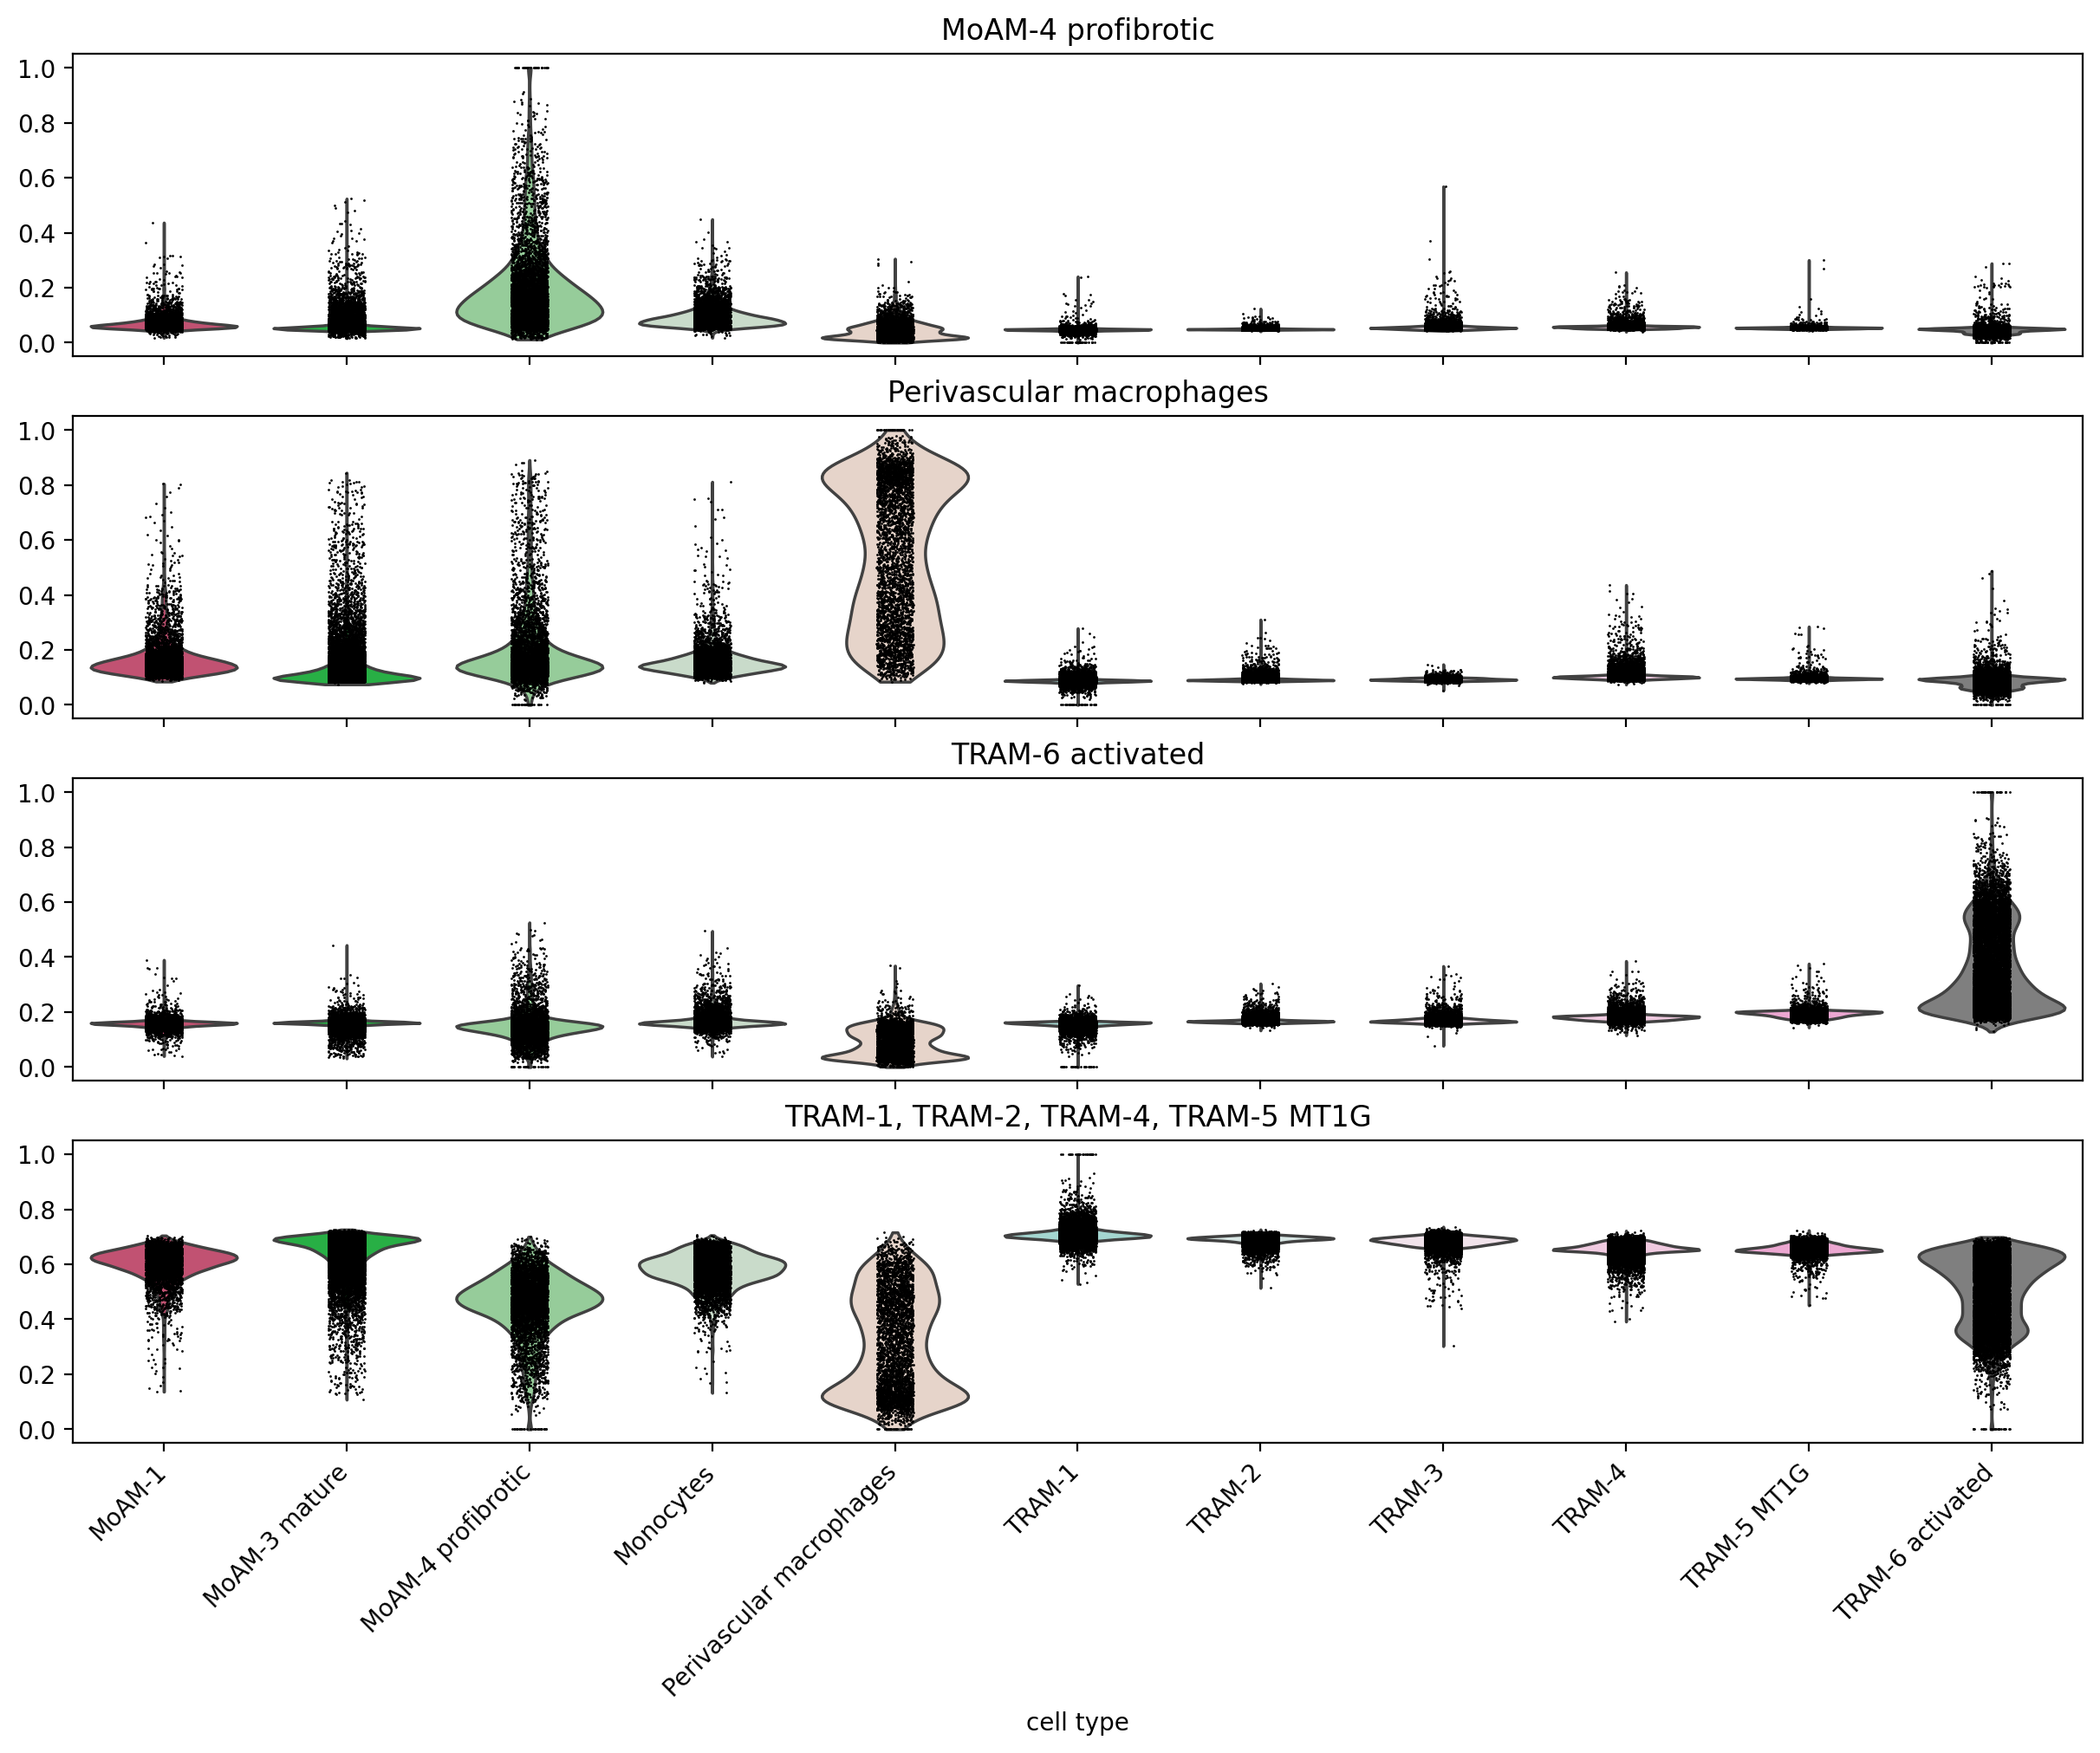

In [12]:
fig, axes = plt.subplots(figsize=(12, 10), constrained_layout=True, nrows=len(LINEAGES), sharex=True)
for name, ax in zip(LINEAGES, axes):
    sc.pl.violin(cellrank_ds, keys=f'Lineage {name}', groupby='cell_type', ax=ax, show=False)
    ax.set_title(name)
    ax.set_ylabel('')
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in axes[-1].get_xticklabels():
    t.set_rotation(45)
    t.set_ha('right')
    t.set_transform(t.get_transform() + trans)

## 2.2 Commitment to TRAM and MoAM-4

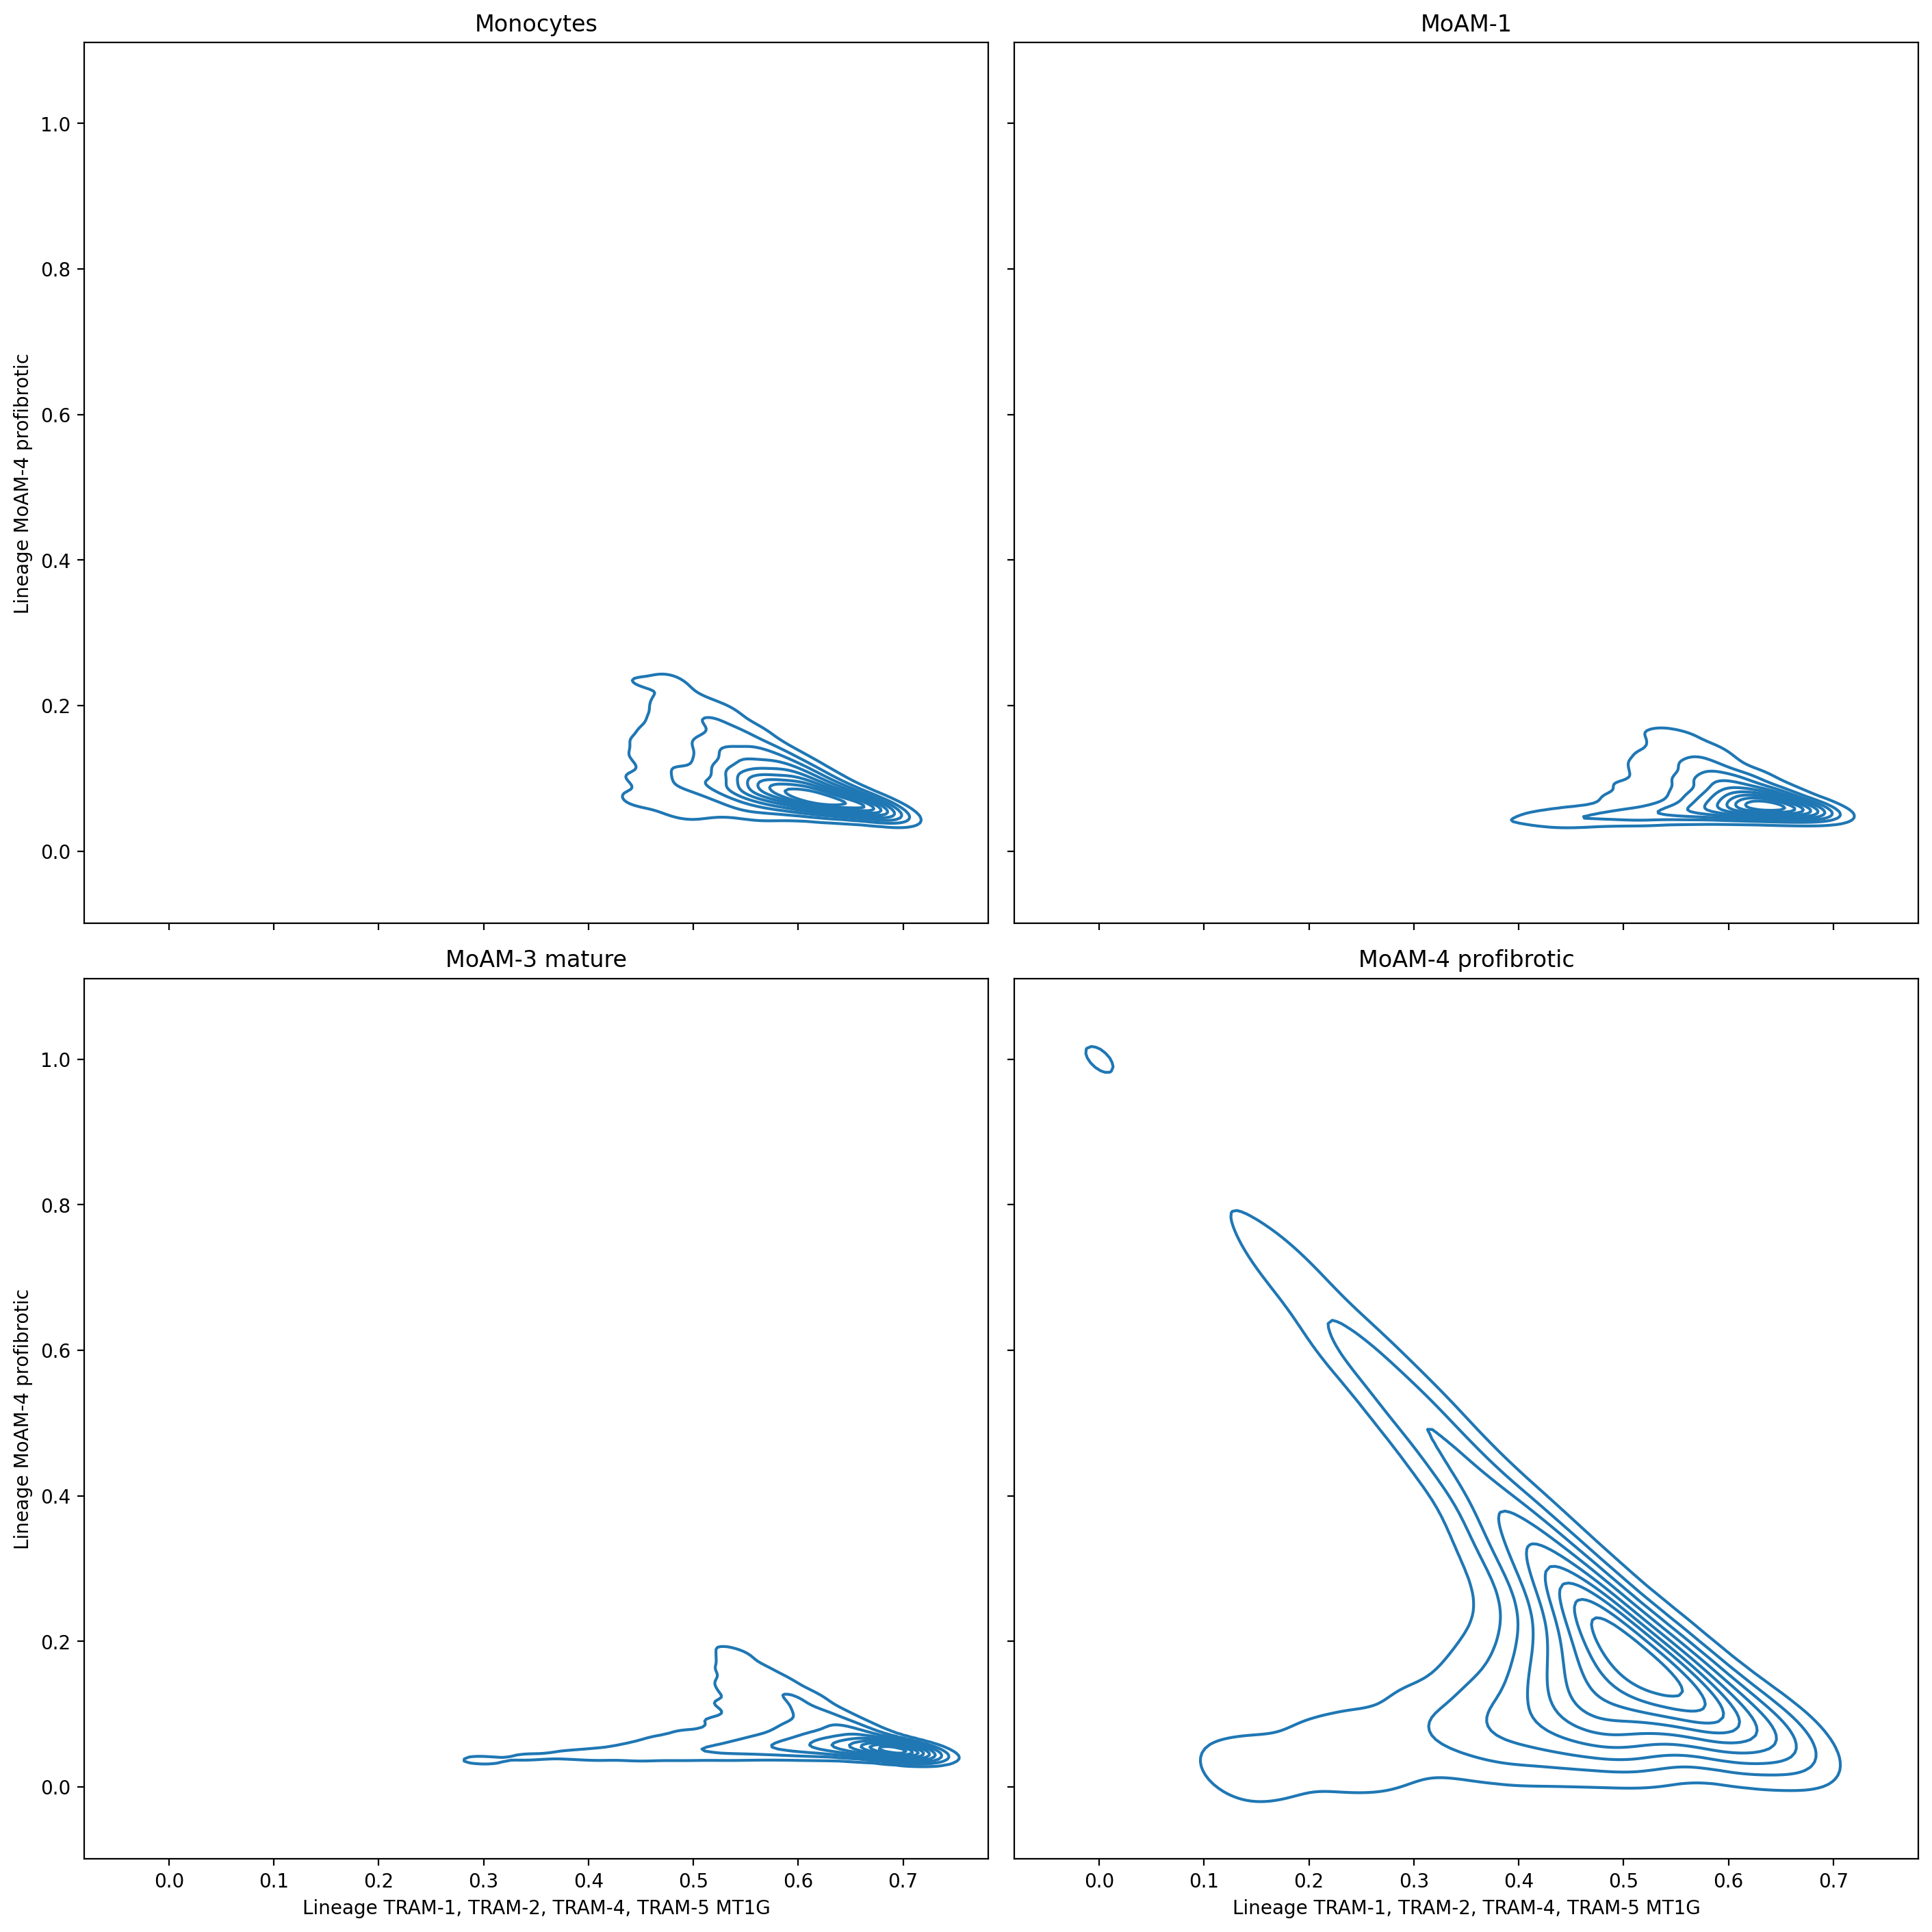

In [13]:
fig, axes = plt.subplots(
    figsize=(14, 14), 
    constrained_layout=True, 
    nrows=2, 
    ncols=2,
    sharex=True,
    sharey=True
)
for i, ct in enumerate(('Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic')):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(
        data=cellrank_ds.obs.loc[cellrank_ds.obs.cell_type.eq(ct)],
        x='Lineage TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G',
        y='Lineage MoAM-4 profibrotic',
        ax=ax
    )
    ax.set_title(ct)

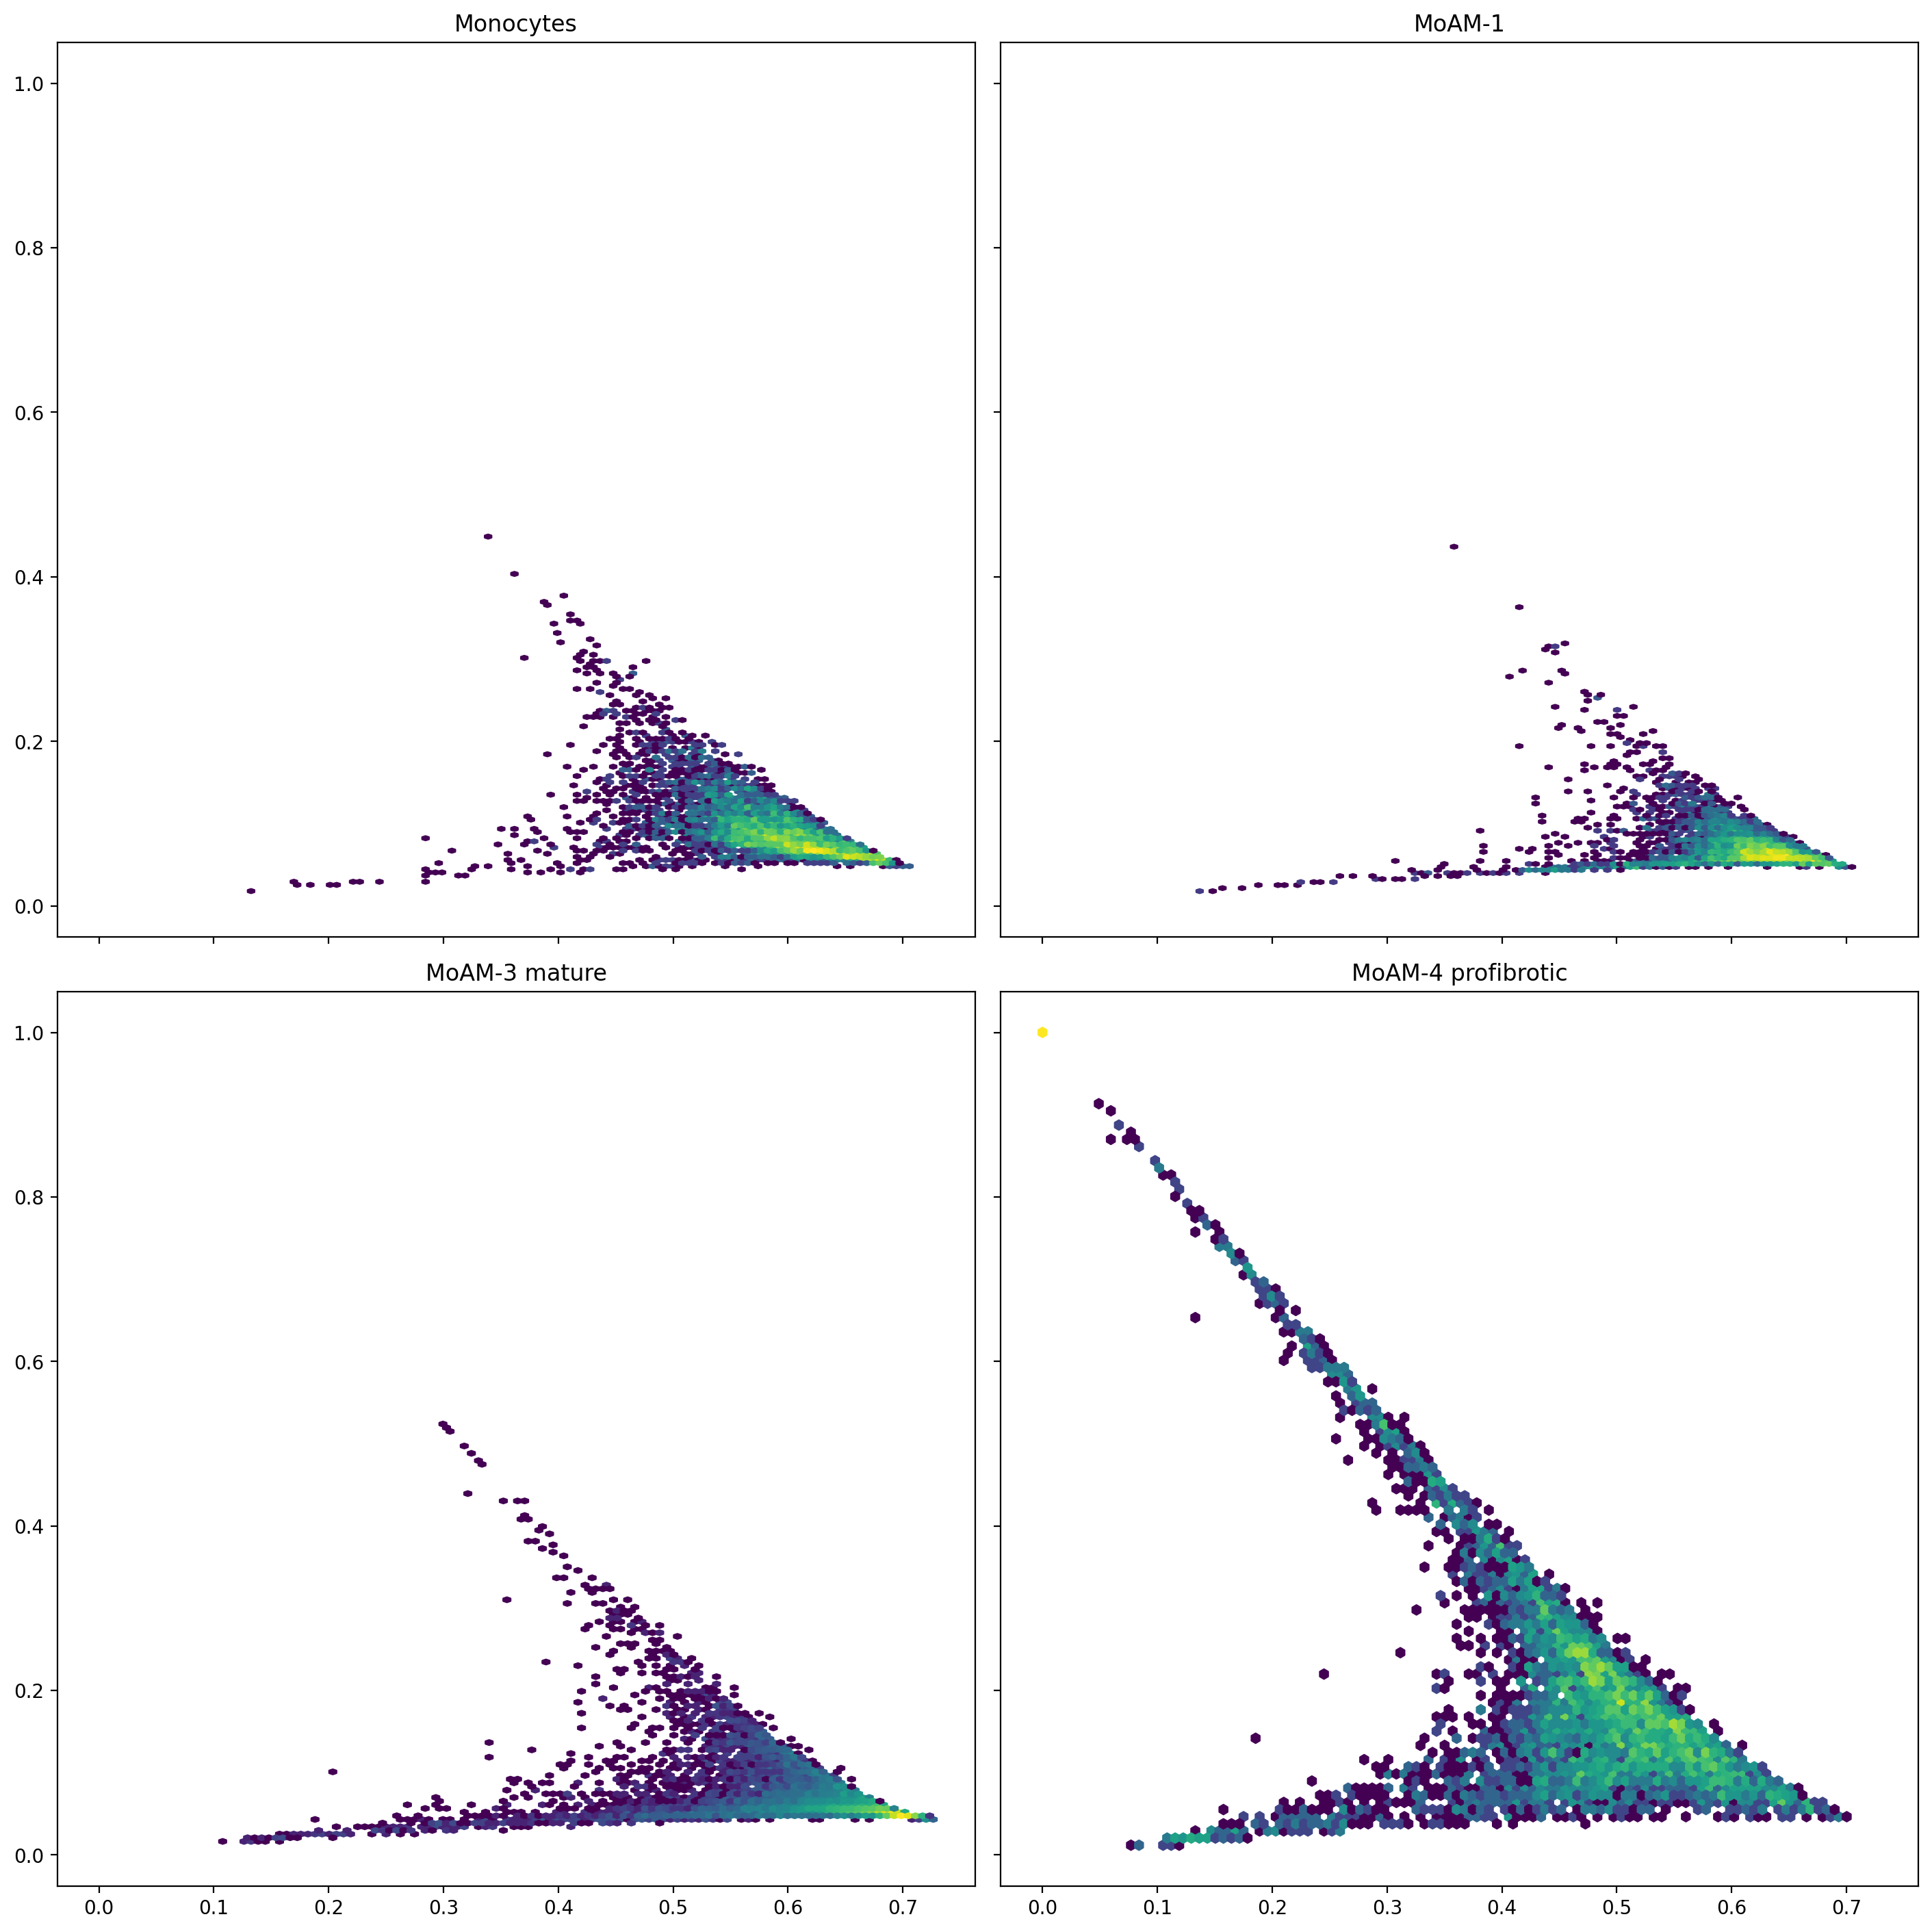

In [14]:
fig, axes = plt.subplots(
    figsize=(14, 14), 
    constrained_layout=True, 
    nrows=2, 
    ncols=2, 
    sharex=True, 
    sharey=True
)
for i, ct in enumerate(('Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic')):
    ax = axes[i // 2, i % 2]
    df_slice = cellrank_ds.obs.loc[cellrank_ds.obs.cell_type.eq(ct)]
    ax.hexbin(
        df_slice['Lineage TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G'],
        df_slice['Lineage MoAM-4 profibrotic'],
        bins='log'
    )
    ax.set_title(ct)

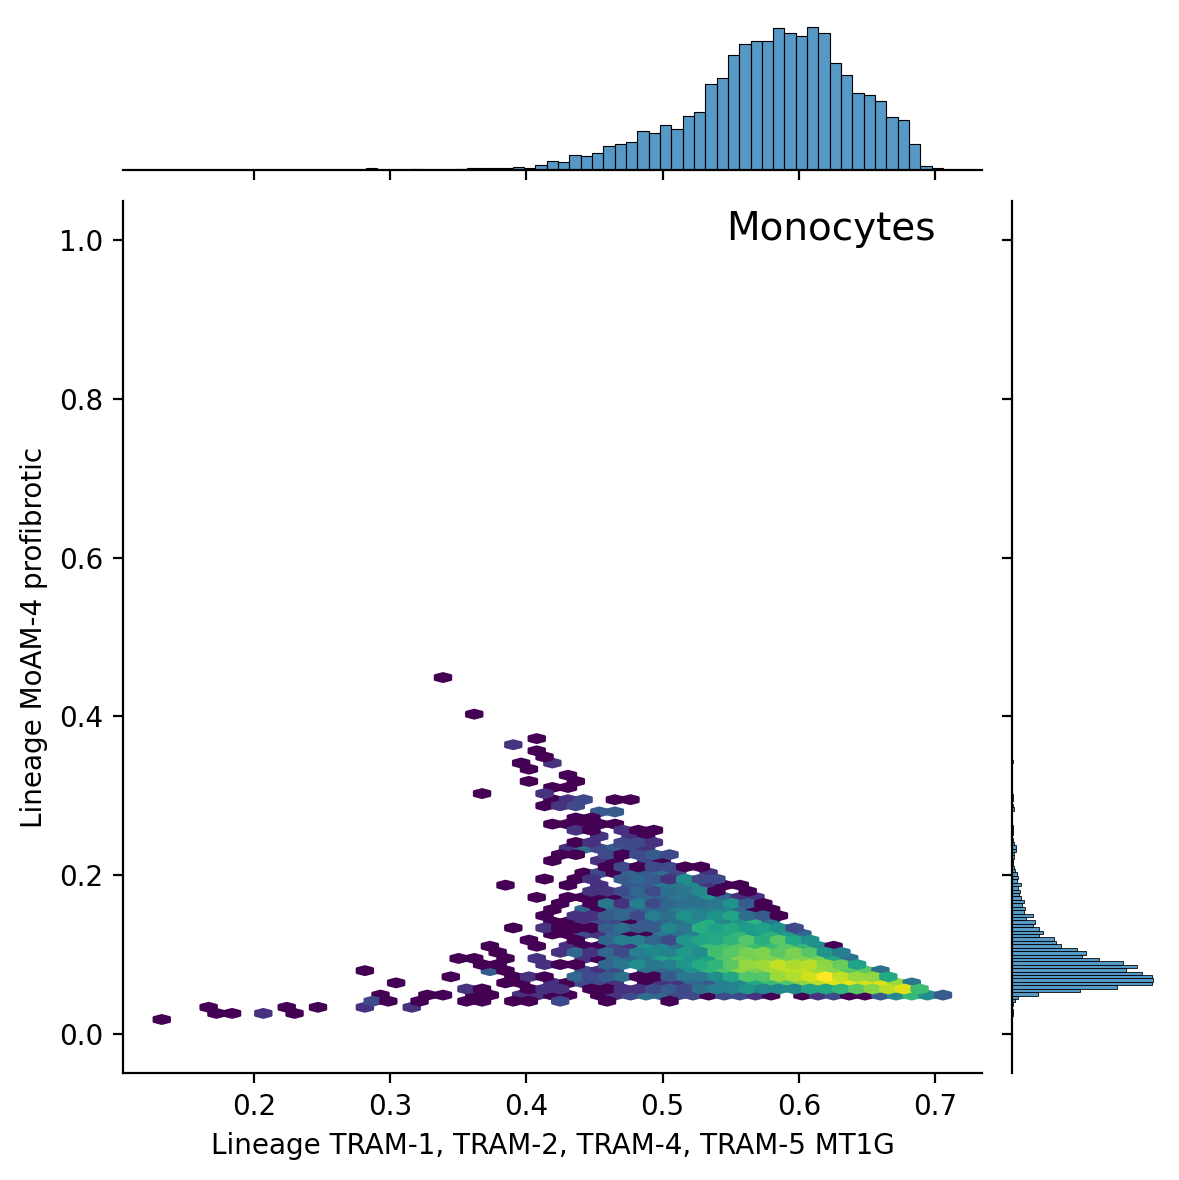

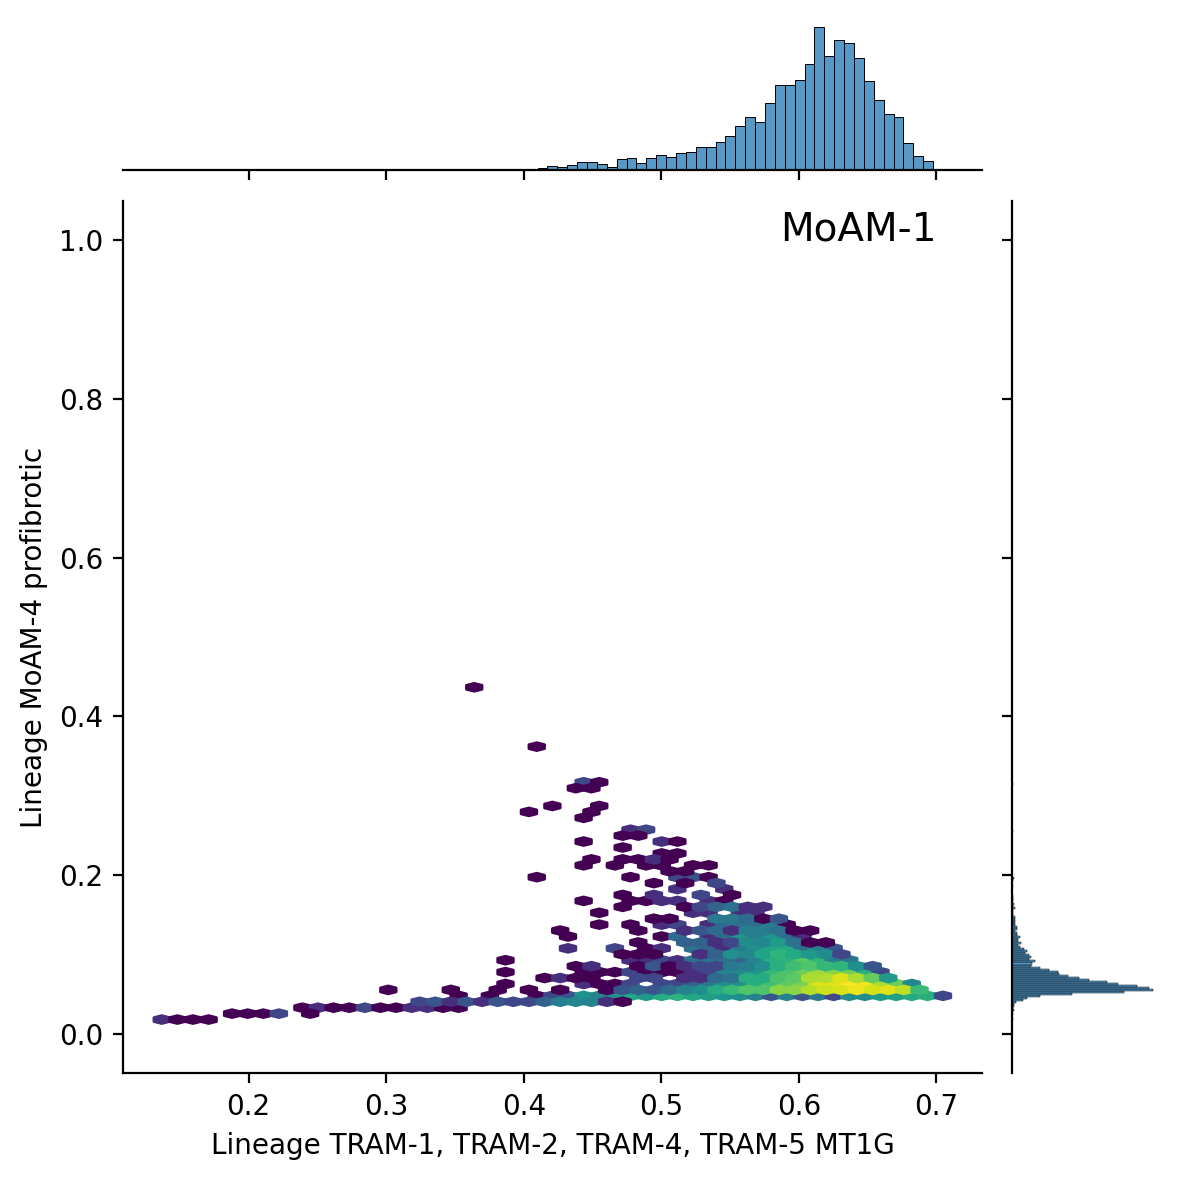

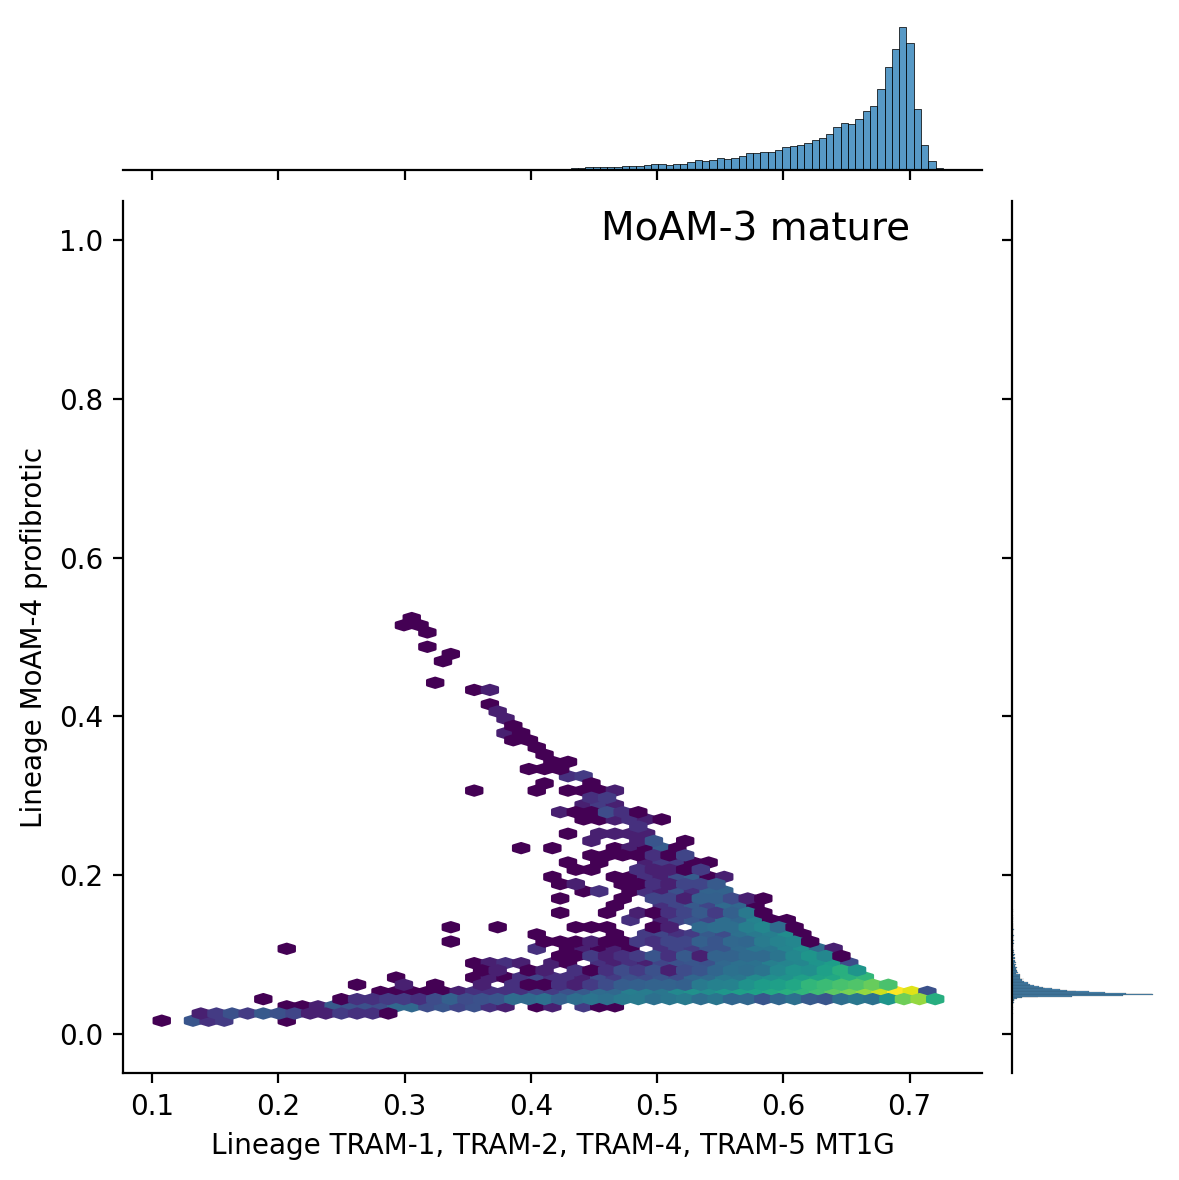

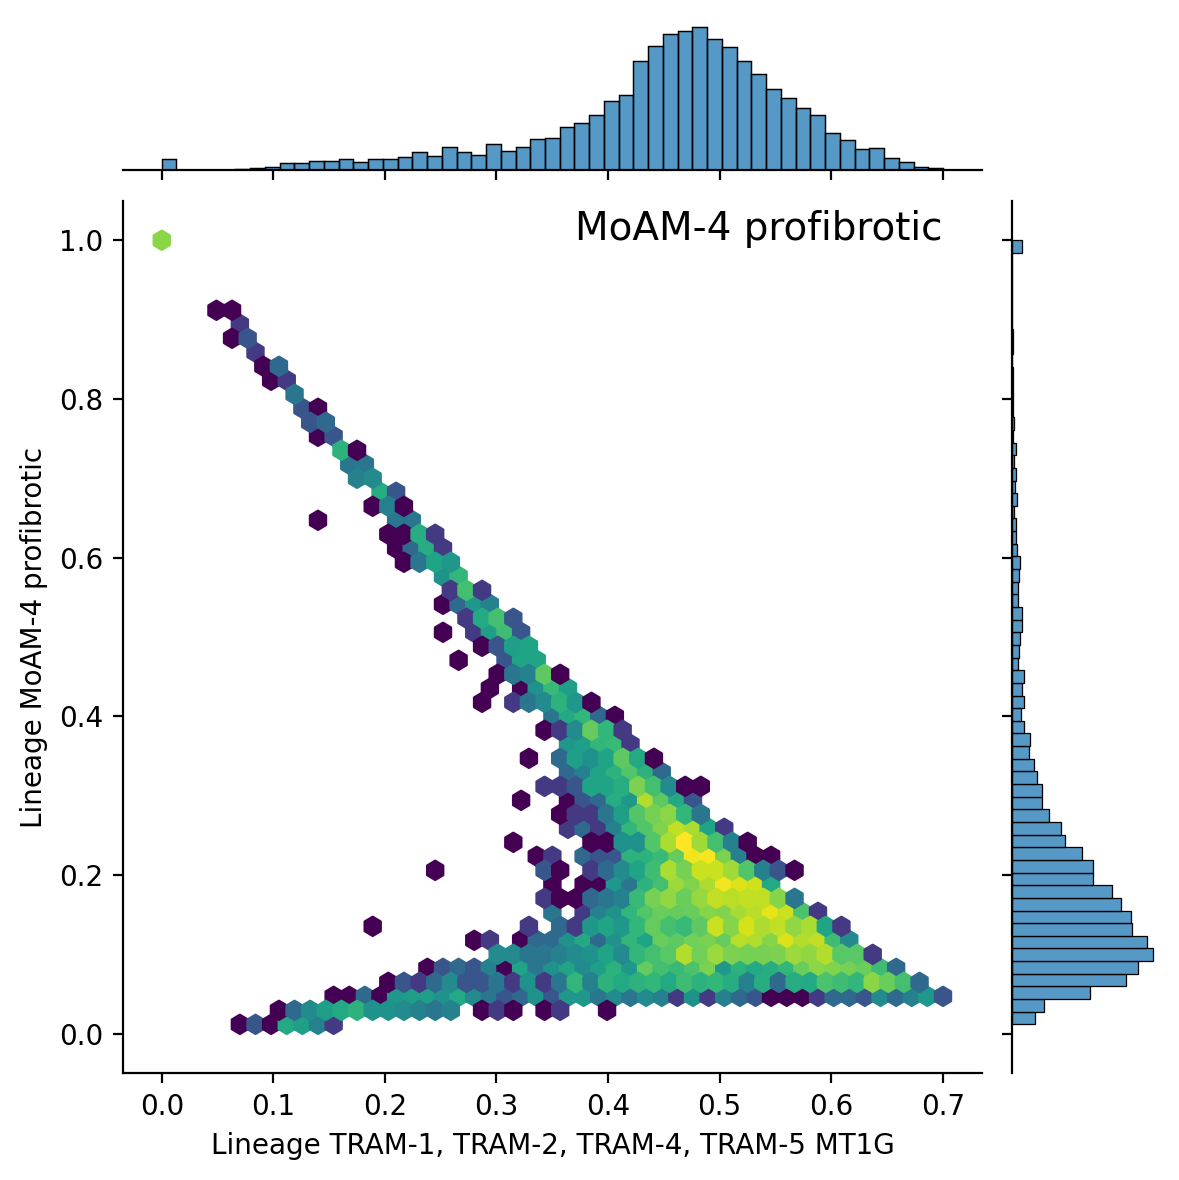

In [67]:
for i, ct in enumerate(('Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic')):
    df_slice = cellrank_ds.obs.loc[cellrank_ds.obs.cell_type.eq(ct)]
    q = sns.jointplot(
        data=df_slice,
        x='Lineage TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G',
        y='Lineage MoAM-4 profibrotic',
        kind='hex',
        joint_kws={
            'bins': 'log',
            'cmap': 'viridis'
        }
    )
    q.ax_joint.set_ylim(-0.05, 1.05)
    q.ax_joint.text(0.7, 1, ct, size=14, ha='right')
    plt.show()

In [61]:
q.ax_joint

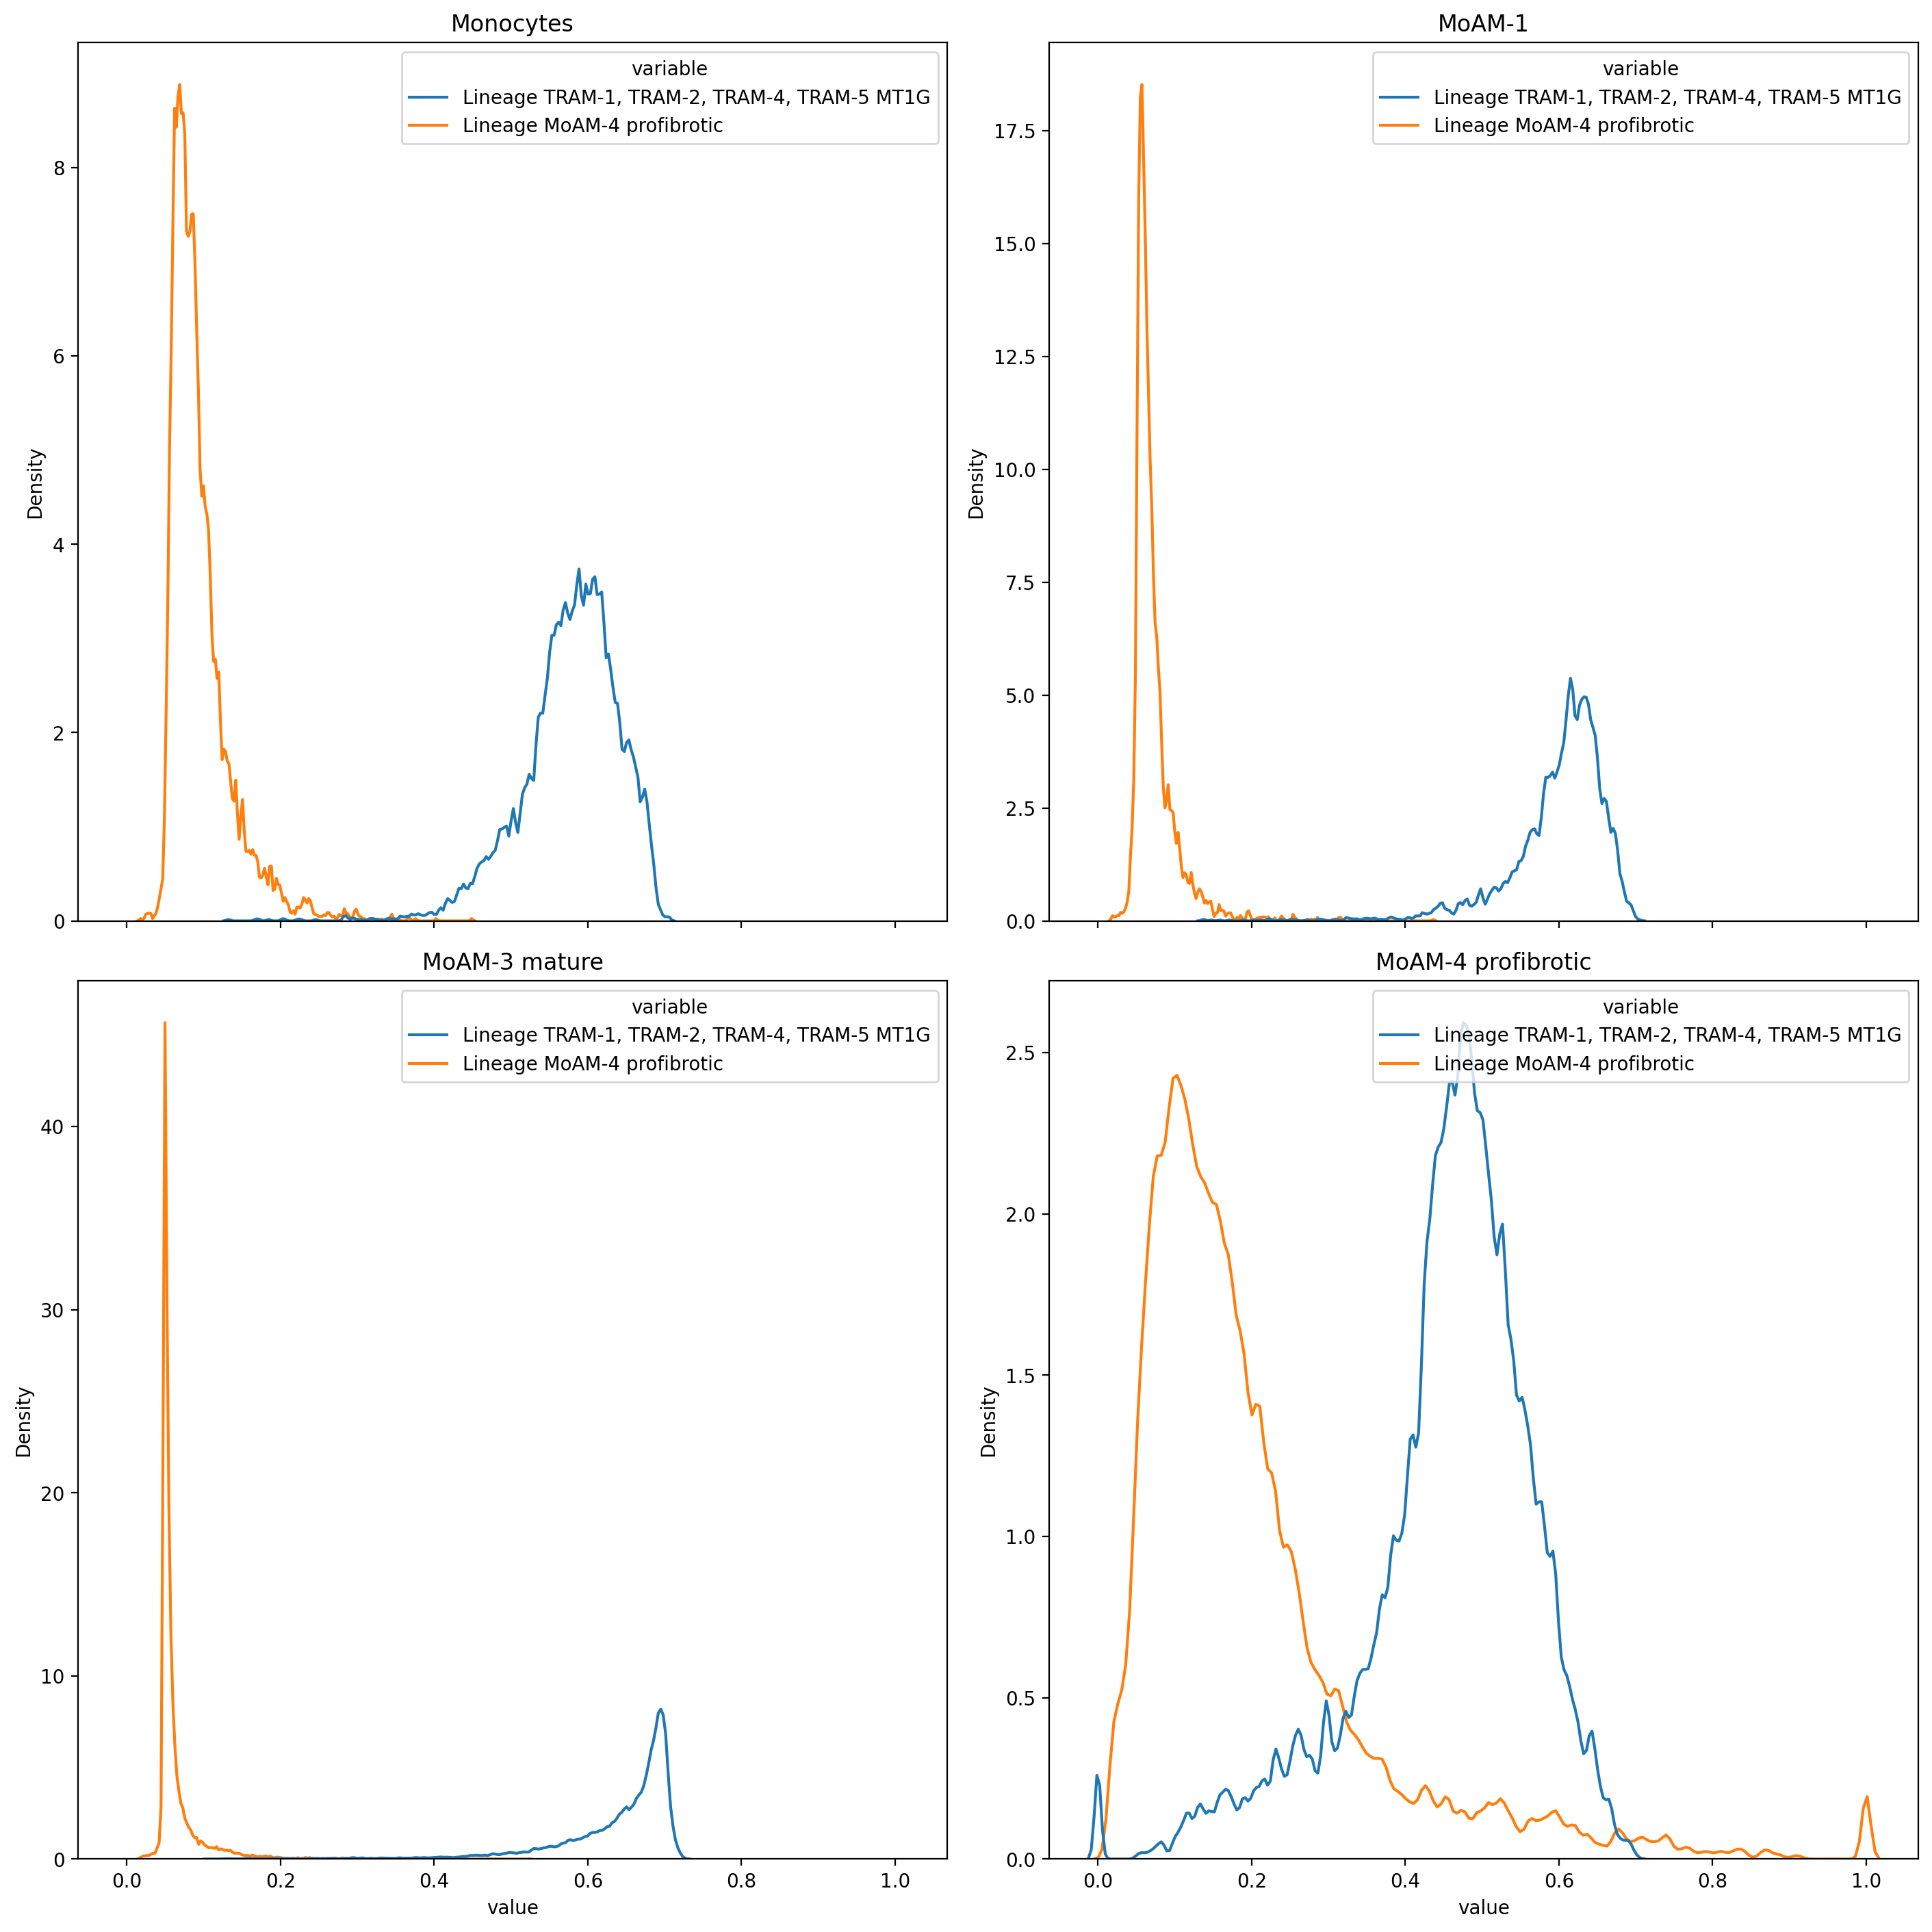

In [15]:
fig, axes = plt.subplots(
    figsize=(14, 14), 
    constrained_layout=True, 
    nrows=2, 
    ncols=2,
    sharex=True,
)
for i, ct in enumerate(('Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic')):
    ax = axes[i // 2, i % 2]
    df_slice = cellrank_ds.obs.loc[
        cellrank_ds.obs.cell_type.eq(ct),
        ['Lineage TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G', 'Lineage MoAM-4 profibrotic']
    ].copy()
    df_slice = df_slice.melt()
    sns.kdeplot(
        data=df_slice,
        x='value',
        hue='variable',
        bw_adjust=0.2,
        ax=ax,
    )
    ax.set_title(ct)

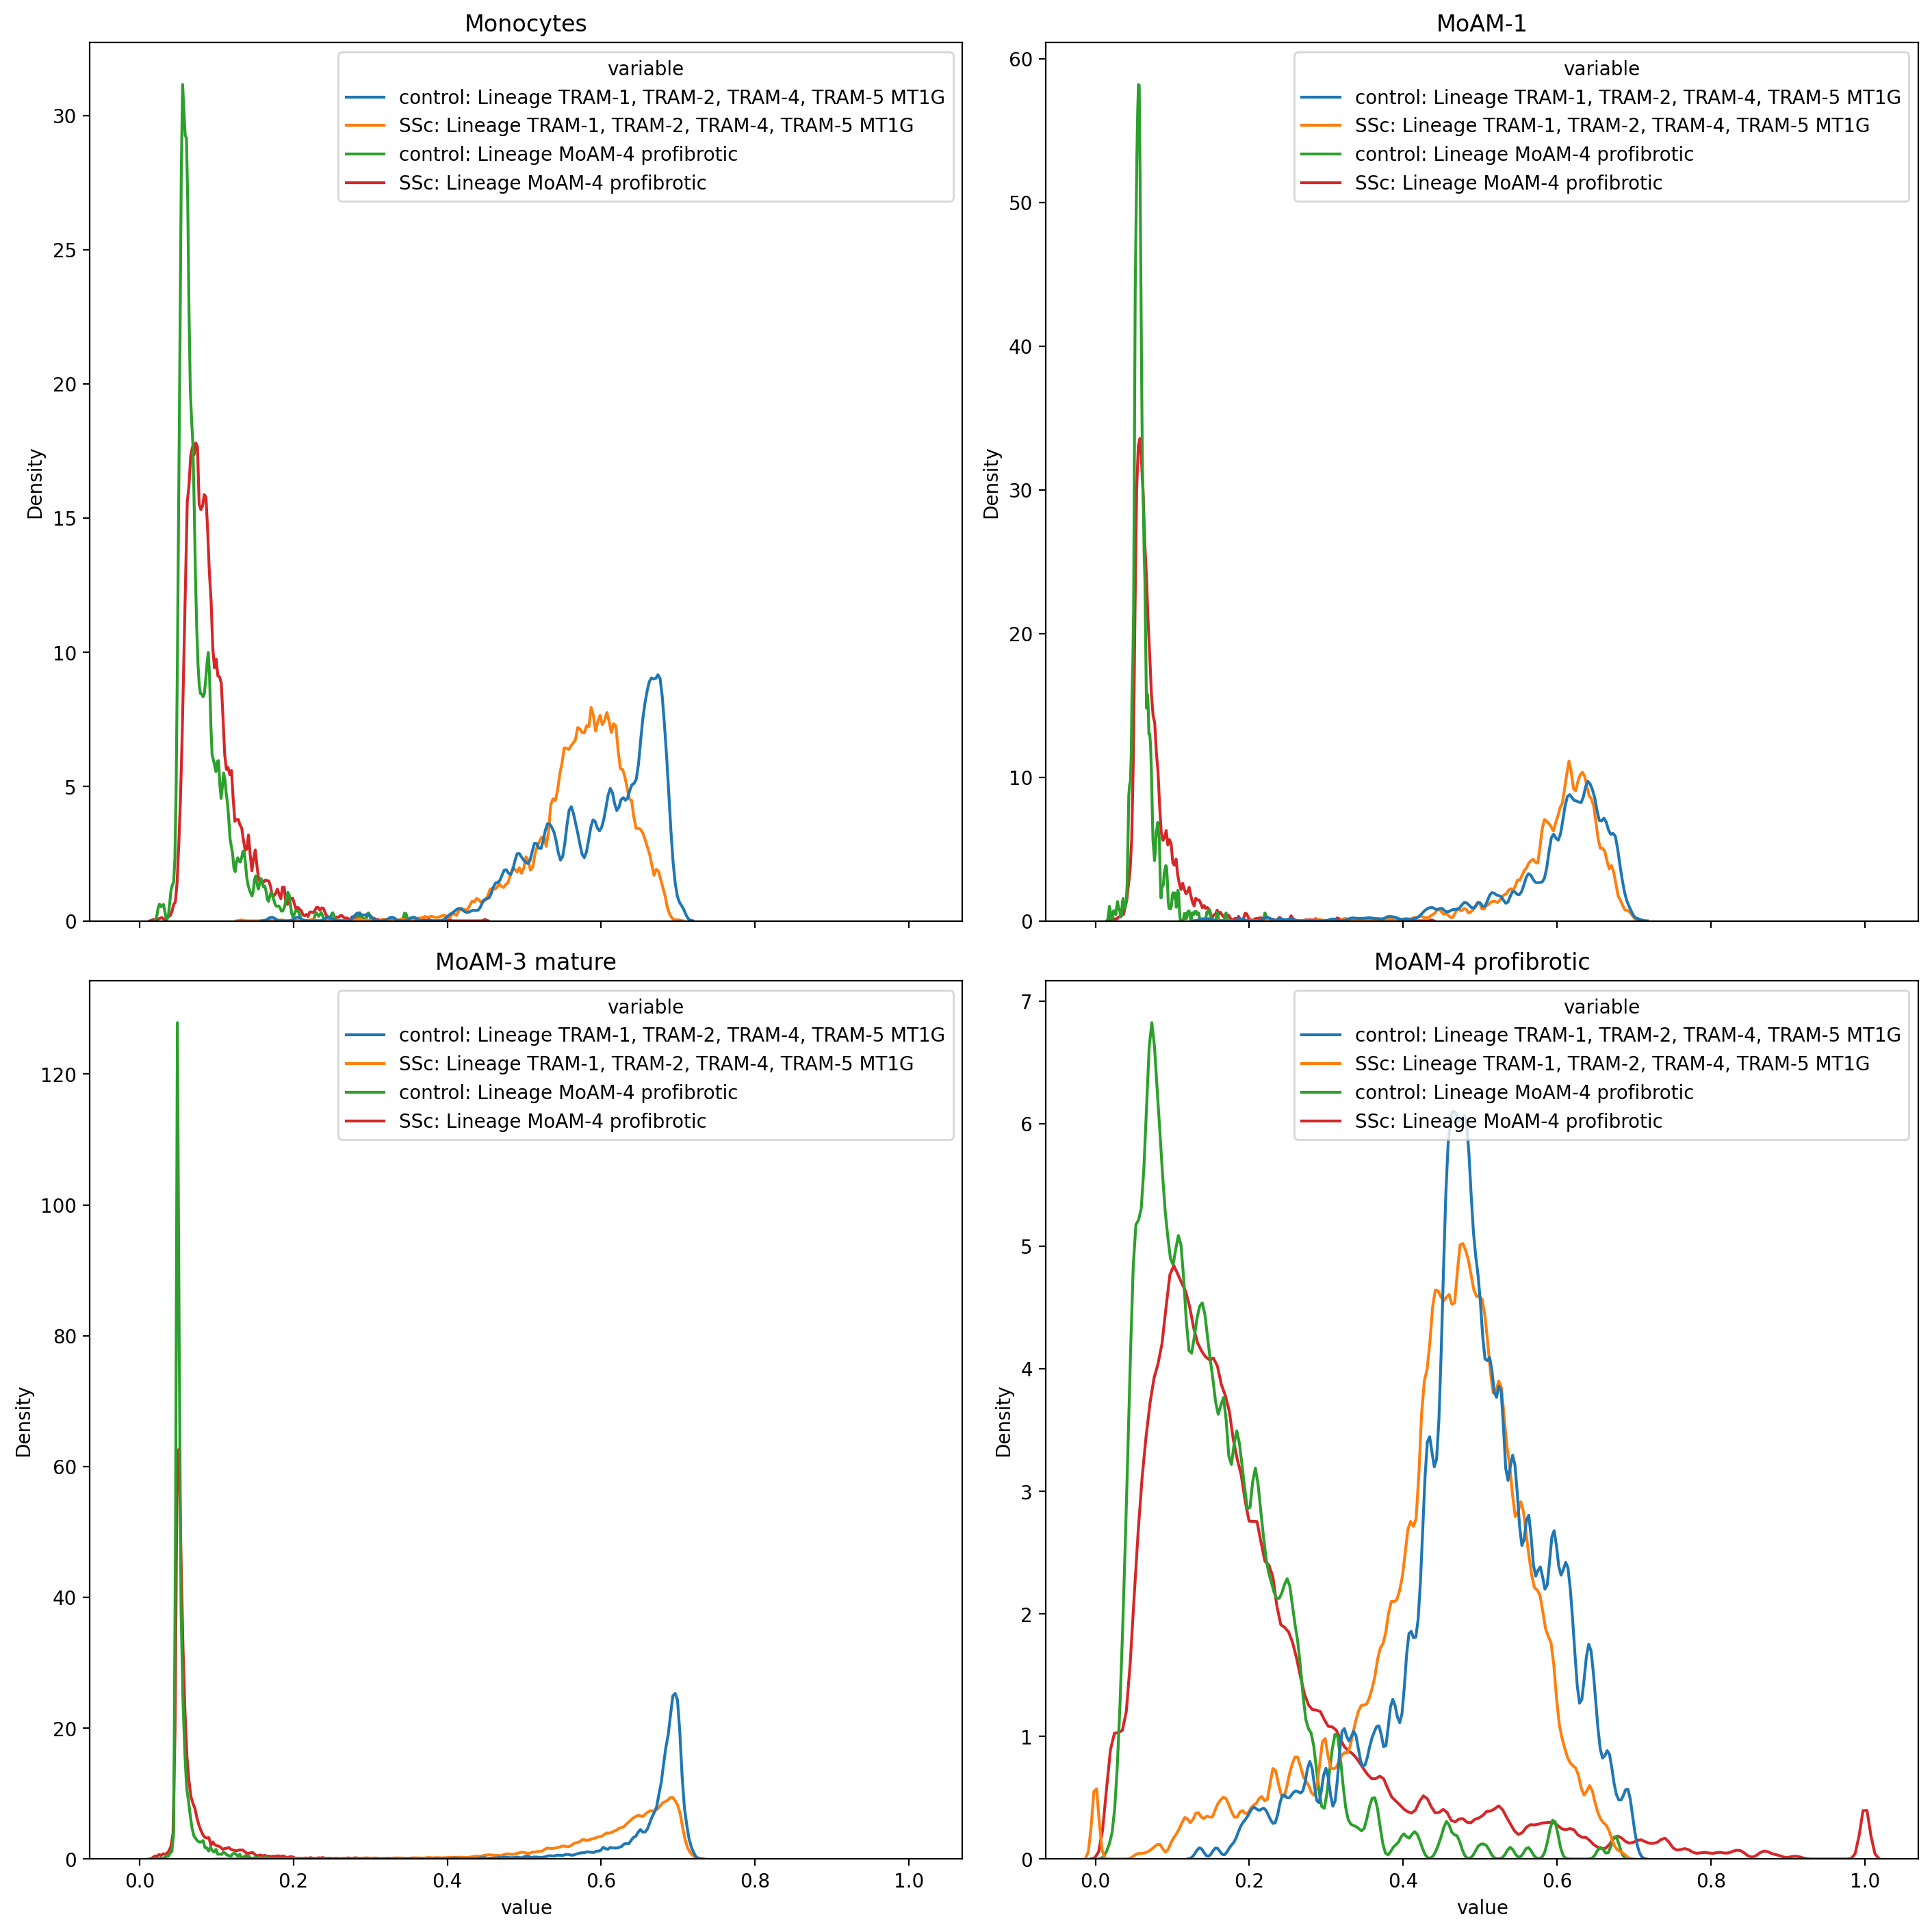

In [16]:
fig, axes = plt.subplots(
    figsize=(14, 14), 
    constrained_layout=True, 
    nrows=2, 
    ncols=2,
    sharex=True,
)
for i, ct in enumerate(('Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic')):
    ax = axes[i // 2, i % 2]
    df_slice = cellrank_ds.obs.loc[
        cellrank_ds.obs.cell_type.eq(ct),
        ['Lineage TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G', 'Lineage MoAM-4 profibrotic', 'Status']
    ].copy()
    df_slice = df_slice.melt(id_vars='Status')
    df_slice['variable'] = df_slice.Status.astype(str) + ': ' + df_slice.variable
    sns.kdeplot(
        data=df_slice,
        x='value',
        hue='variable',
        bw_adjust=0.2,
        ax=ax,
        common_norm=False
    )
    ax.set_title(ct)

## Pseudobulk of lineage probabilities

In [17]:
metadata_df = cellrank_ds.obs[
    ['External Sample ID', 'cell_type', 'Status']
].groupby(['External Sample ID', 'cell_type', 'Status'], observed=True).size().reset_index(name='n_cells')

In [18]:
metadata_df = metadata_df.loc[metadata_df.n_cells.ge(10) & metadata_df.cell_type.isin([
    'Monocytes', 'MoAM-1', 'MoAM-3 mature'
])]

In [19]:
metadata_df.Status = metadata_df.Status.cat.reorder_categories(['control', 'SSc'])
metadata_df.cell_type = metadata_df.cell_type.cat.remove_unused_categories().cat.reorder_categories([
    'Monocytes', 'MoAM-1', 'MoAM-3 mature'
])

In [22]:
pseudobulk = np.zeros((metadata_df.shape[0], cellrank_ds.obsm['lineages_fwd'].shape[1]))
for i, (_, metadata_row) in enumerate(metadata_df.iterrows()):
    metadata_idx = (
        cellrank_ds.obs.cell_type.eq(metadata_row.cell_type)
        & cellrank_ds.obs['External Sample ID'].eq(metadata_row['External Sample ID'])
    )
    pseudobulk[i, :] = cellrank_ds.obsm['lineages_fwd'][metadata_idx.to_numpy()].mean(axis=0)

In [24]:
pseudobulk = pd.DataFrame(pseudobulk, index=metadata_df.index, columns=LINEAGES)

In [25]:
pseudobulk.shape

(65, 4)

In [26]:
sample_order = metadata_df.sort_values(
    ['Status', 'cell_type', 'External Sample ID']
).index

In [53]:
def plot_stats_boxplot(ax, df, value_col):
    stats_results = []
    for ct in df.cell_type.unique():
        vals1 = df[value_col][df.cell_type.eq(ct) & df.Status.eq('control')]
        vals2 = df[value_col][df.cell_type.eq(ct) & df.Status.eq('SSc')]
        if vals1.size == 0 or vals2.size == 0:
            continue
        pval = scipy.stats.ttest_ind(vals1, vals2).pvalue
        stats_results.append([ct, 'control', 'SSc', vals1.size, vals2.size, pval])
    
    stats_results = pd.DataFrame(
        stats_results, 
        columns=['cell_type', 'group1', 'group2', 'group1_size', 'group2_size', 'pval']
    )
    stats_results['padj'] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval)[1]
    stats_results_sign = stats_results.loc[stats_results.padj.lt(0.05)]

    sns.boxplot(
        data=df,
        x='cell_type',
        y=value_col,
        hue='Status',
        palette=['royalblue', 'firebrick'],
        saturation=1,
        showfliers=False,
        linecolor='k',
        ax=ax
    )
    sns.swarmplot(
        data=df,
        x='cell_type',
        y=value_col,
        hue='Status',
        dodge=True,
        palette=['k', 'k'],
        # jitter=0.2,
        legend=False,
        ax=ax
    )
    plotter = sns.categorical._CategoricalPlotter(
        data=df,
        variables=dict(x='cell_type', y=value_col, hue='Status')
    )
    plotter.scale_categorical(plotter.orient, order=None, formatter=None)
    plotter._attach(ax)
    ylim = ax.get_ylim()
    ax.set_ylim(0, ylim[1])
    
    start_height = df[value_col].max()
    incrementer = 10 # px
    q = ax.transData.inverted().transform([[0, 0], [0, incrementer]])
    y_offset = q[1][1] - q[0][1]
    gap = y_offset * 2
    y = start_height + gap
    for _, r in stats_results_sign.iterrows():
        p = f'{r.padj:.3f}'
        
        # statistical annotation
        # Get x positions from Seaborn
        base_x = ax.xaxis.convert_units(r.cell_type)
        plotter_data = pd.DataFrame({plotter.orient: [base_x], "width": 0.8 * plotter._native_width})
        plotter._dodge({'hue': r.group1}, plotter_data)
        x1 = plotter_data[plotter.orient][0]
        plotter_data = pd.DataFrame({plotter.orient: [base_x], "width": 0.8 * plotter._native_width})
        plotter._dodge({'hue': r.group2}, plotter_data)
        x2 = plotter_data[plotter.orient][0]
        
        col = 'k'
        h = y_offset
        # y += gap
    
        bracket = ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c=col)
        txt = ax.text((x1+x2)*.5, y+.95*h, p, ha='center', va='bottom', color=col, size=6)
        # y += y_offset
    ylim = ax.get_ylim()
    ax.set_ylim(-1 * (ylim[1] / 12), y + y_offset * 3)

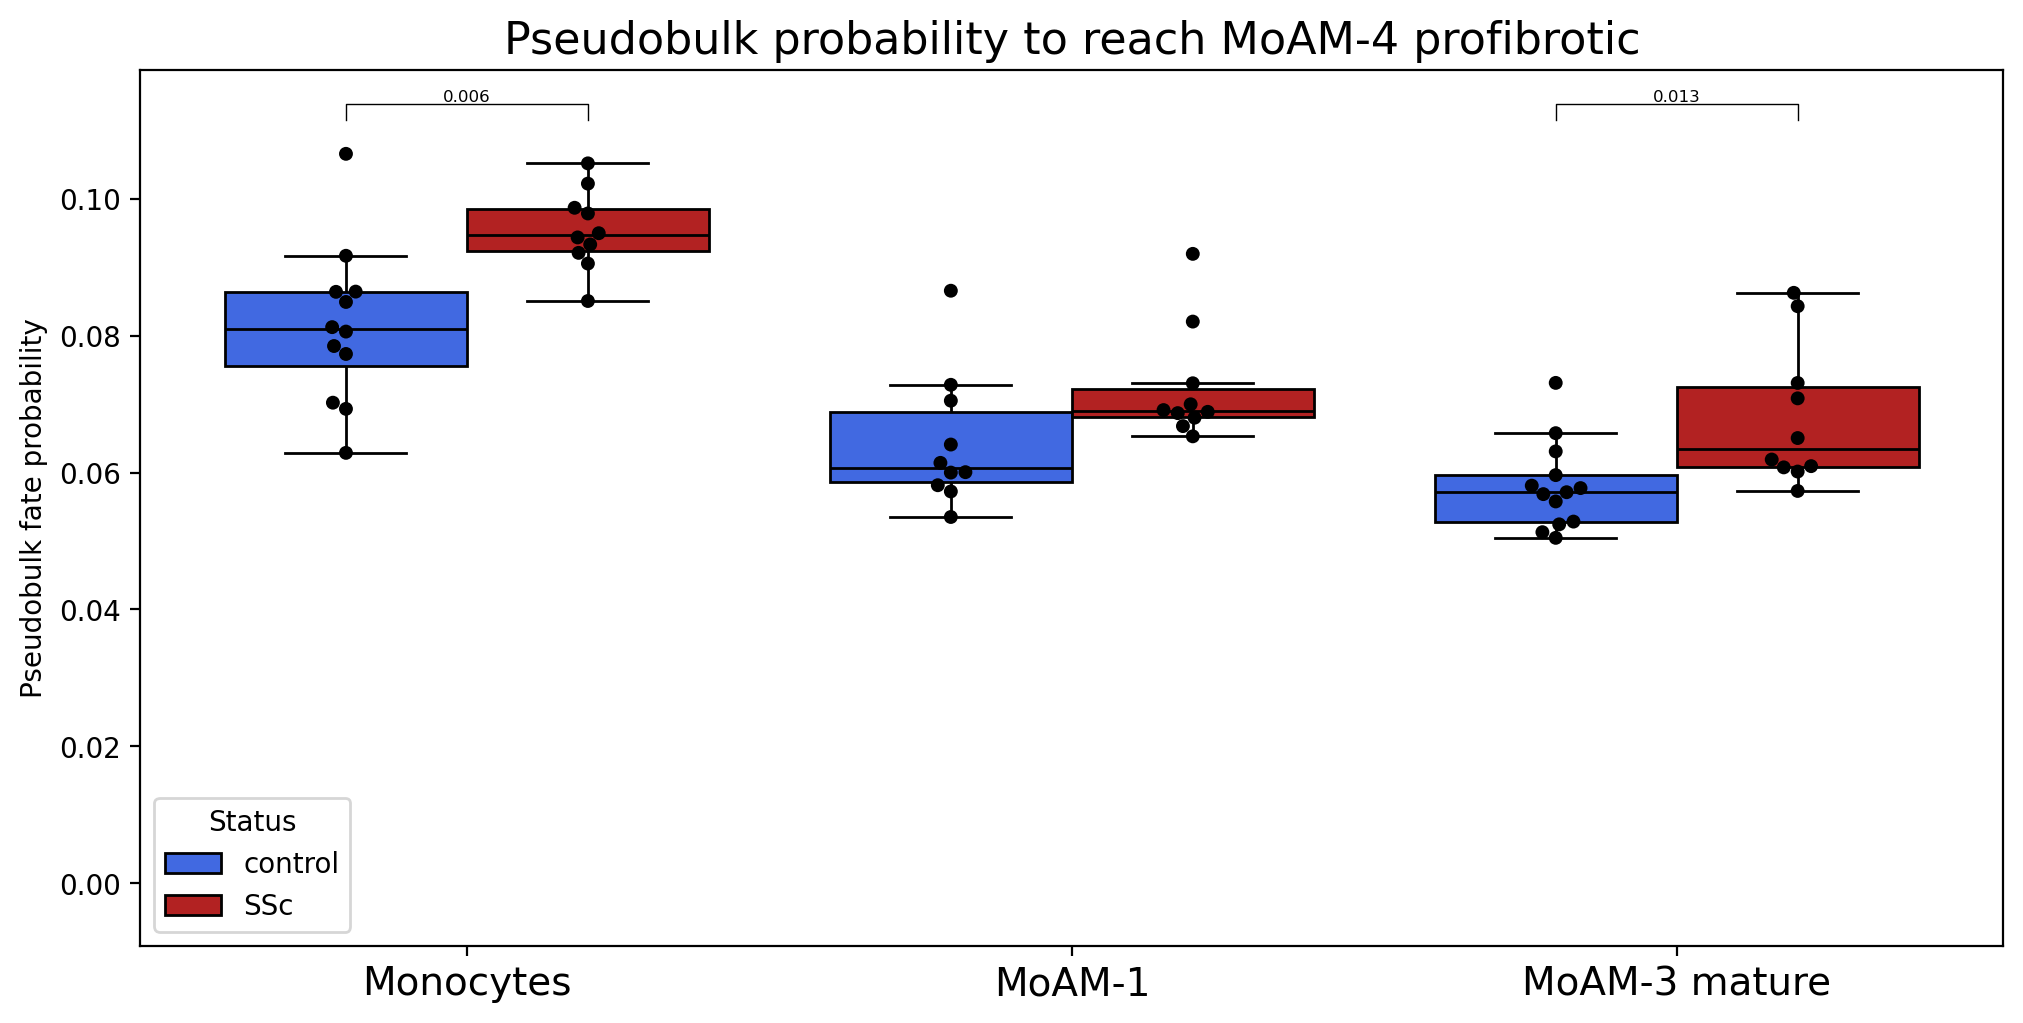

In [54]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
LINEAGE = 'MoAM-4 profibrotic'
df = pseudobulk.merge(metadata_df, left_index=True, right_index=True)
plot_stats_boxplot(ax, df, LINEAGE)
ax.set_title(f'Pseudobulk probability to reach {LINEAGE}', size=16)
ax.set_ylabel(f'Pseudobulk fate probability')
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)

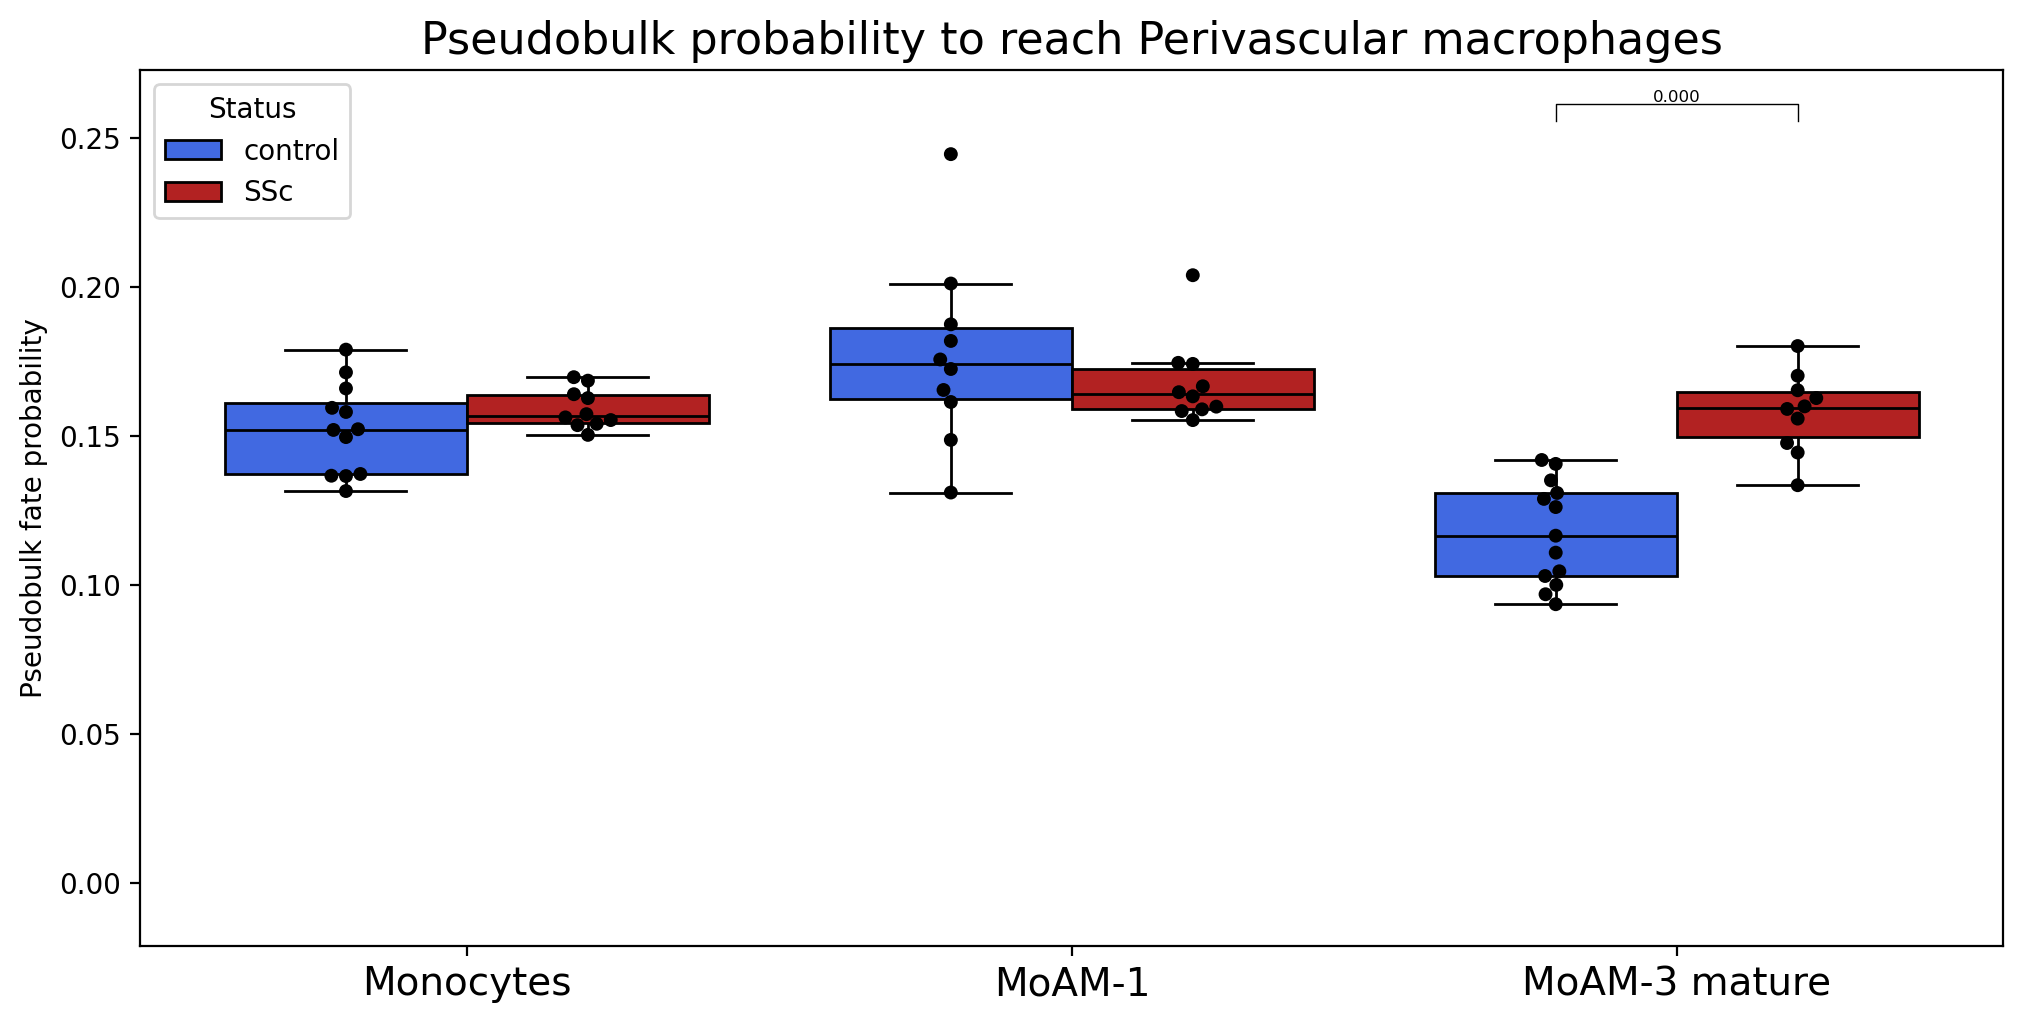

In [55]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
LINEAGE = 'Perivascular macrophages'
df = pseudobulk.merge(metadata_df, left_index=True, right_index=True)
plot_stats_boxplot(ax, df, LINEAGE)
ax.set_title(f'Pseudobulk probability to reach {LINEAGE}', size=16)
ax.set_ylabel(f'Pseudobulk fate probability')
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)

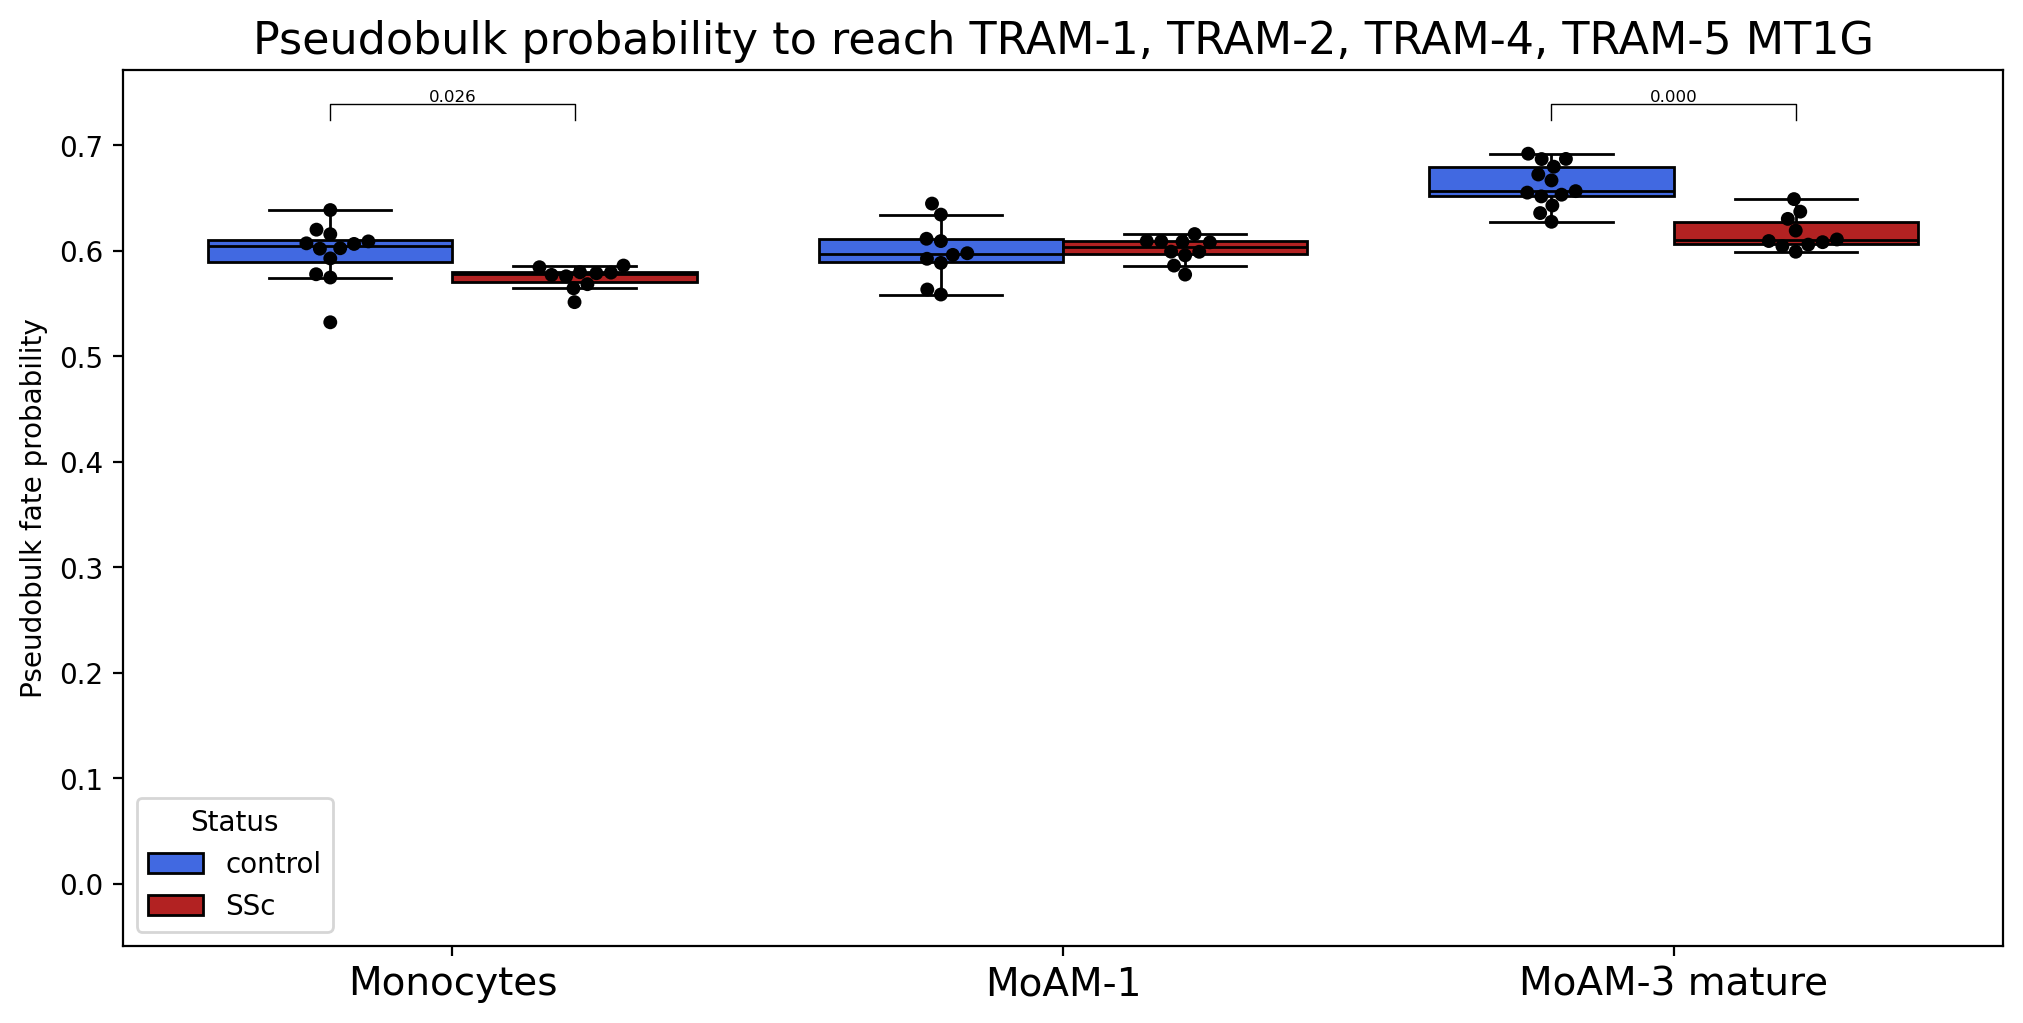

In [56]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
LINEAGE = 'TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G'
df = pseudobulk.merge(metadata_df, left_index=True, right_index=True)
plot_stats_boxplot(ax, df, LINEAGE)
ax.set_title(f'Pseudobulk probability to reach {LINEAGE}', size=16)
ax.set_ylabel(f'Pseudobulk fate probability')
ax.set_xlabel('')
ax.tick_params(axis='x', labelsize=14)

# 3. Programs that are correlated with commitment

## 3.1 Heatmap of programs by pseudotime

In Monocytes, MoAM-1 and MoAM-3 mature only

In [17]:
ds = ds[cellrank_ds.obs_names].copy()

In [18]:
ds.obs['dpt_pseudotime'] = cellrank_ds.obs.dpt_pseudotime

In [19]:
for lineage in LINEAGES:
    ds.obs[f'Lineage {lineage}'] = cellrank_ds.obs[f'Lineage {lineage}']

In [20]:
df = ds.obs.loc[ds.obs.cell_type.isin(['Monocytes', 'MoAM-1', 'MoAM-3 mature'])].copy()

In [21]:
factor_idx = df.columns.str.startswith('F_')

In [22]:
non_myeloid_factors = df.columns[factor_idx][df.loc[:, factor_idx].max().eq(0)]

In [23]:
df.drop(columns=non_myeloid_factors, inplace=True)

In [24]:
factor_idx = df.columns.str.startswith('F_')

In [25]:
df = df.sort_values('dpt_pseudotime')

In [26]:
col_colors = get_color_annotations(df, {
    'dpt_pseudotime': 'viridis',
    'Status': ['firebrick', 'royalblue'],
    'cell_type': 'tab10'
})

/tmp/ipykernel_14384/280344997.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):
/tmp/ipykernel_14384/280344997.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):


/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/cellrank_venv/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


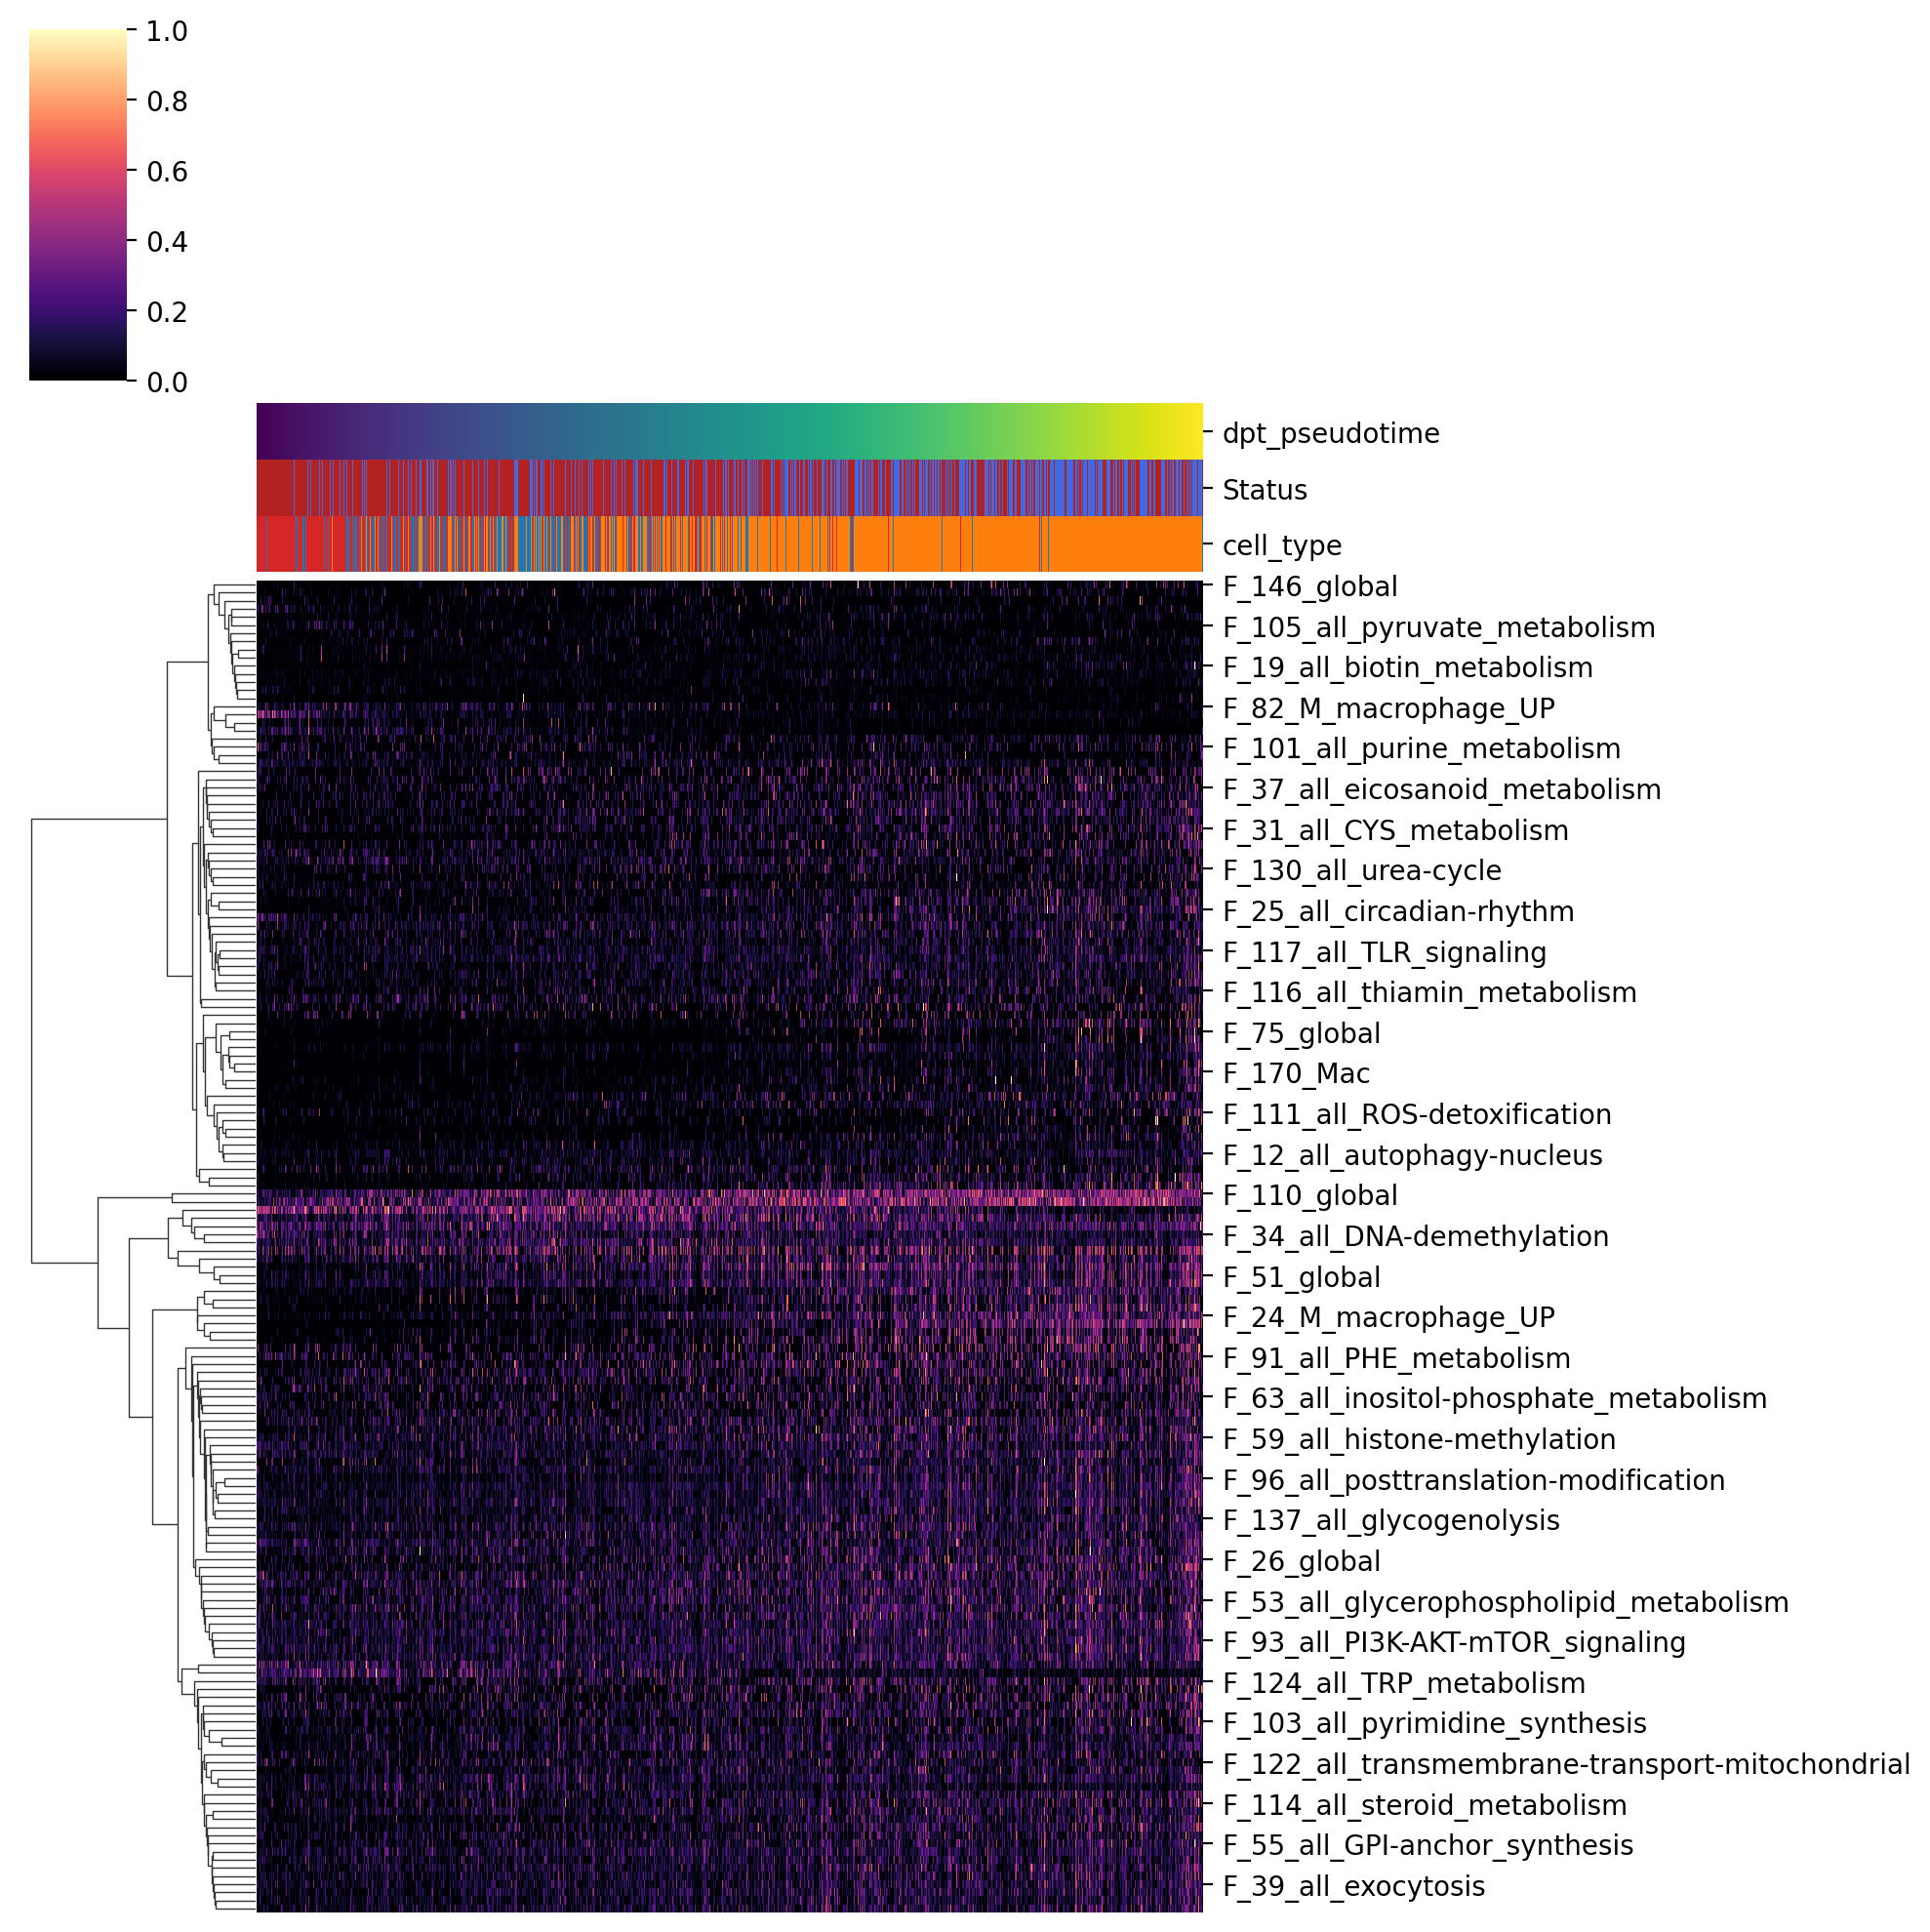

In [27]:
sns.clustermap(
    df.loc[:, factor_idx].T,
    col_colors=col_colors,
    col_cluster=False,
    row_cluster=True,
    standard_scale=0,
    cmap='magma',
    method='ward',
    xticklabels=[]
)

## 3.2 Correlate with pseudotime

In [28]:
stats = []
for factor in df.columns[factor_idx]:
    res = scipy.stats.spearmanr(df.dpt_pseudotime, df[factor])
    stats.append((factor, res.statistic, res.pvalue))
stats = pd.DataFrame(stats, columns=['factor', 'spearman_rho', 'pval'])
stats.loc[stats.pval.eq(0), 'pval'] = stats.pval[stats.pval.gt(0)].min() * 0.1
stats['padj'] = statsmodels.stats.multitest.fdrcorrection(stats.pval)[1]

In [29]:
stats.sort_values('padj').head(30)

factor  spearman_rho           pval  \
112     F_112_all_selenoamino-acid_metabolism      0.239638  1.608810e-311   
81                F_81_all_n-glycan_synthesis      0.239595  1.608810e-311   
78                                F_78_global      0.273787  1.608810e-311   
76         F_76_all_mitotic-spindle-component      0.232797  1.608810e-311   
75                                F_75_global      0.238245  1.608810e-311   
74                    F_74_all_macroautophagy      0.276192  1.608810e-311   
70                    F_70_all_macroautophagy      0.228353  1.608810e-311   
69                       F_69_M_macrophage_UP      0.440259  1.608810e-311   
114              F_114_all_steroid_metabolism      0.239830  1.608810e-311   
113                     F_113_M_macrophage_UP      0.435303  1.608810e-311   
82                       F_82_M_macrophage_UP     -0.330453  1.608810e-311   
110                              F_110_global      0.367230  1.608810e-311   
109  F_109_all_protein-degradation-proteasome      0.245857  1.608810e-311   
66         F_66_all_keratan-sulfate_synthesis      0.354707  1.608810e-311   
65                                F_65_global      0.379845  1.608810e-311   
121                              F_121_global      0.353500  1.608810e-311   
57                                F_57_global      0.274458  1.608810e-311   
55              F_55_all_GPI-anchor_synthesis      0.241744  1.608810e-311   
51                                F_51_global      0.280826  1.608810e-311   
44                                F_44_global      0.323482  1.608810e-311   
6              F_6_all_TNF-via-NFkB_signaling     -0.334279  1.608810e-311   
162                                 F_169_Mac     -0.503892  1.608810e-311   
161                                 F_168_Mac      0.420263  1.608810e-311   
24                       F_24_M_macrophage_UP      0.504885  1.608810e-311   
22                                F_22_global      0.253171  1.608810e-311   
19                 F_19_all_biotin_metabolism      0.235867  1.608810e-311   
154                                 F_161_Mac      0.373402  1.608810e-311   
153                 F_160_Mac_M_macrophage_UP      0.726471  1.608810e-311   
151                              F_151_global      0.313764  1.608810e-311   
147                              F_147_global      0.522458  1.608810e-311   

              padj  
112  4.471946e-311  
81   4.471946e-311  
78   4.471946e-311  
76   4.471946e-311  
75   4.471946e-311  
74   4.471946e-311  
70   4.471946e-311  
69   4.471946e-311  
114  4.471946e-311  
113  4.471946e-311  
82   4.471946e-311  
110  4.471946e-311  
109  4.471946e-311  
66   4.471946e-311  
65   4.471946e-311  
121  4.471946e-311  
57   4.471946e-311  
55   4.471946e-311  
51   4.471946e-311  
44   4.471946e-311  
6    4.471946e-311  
162  4.471946e-311  
161  4.471946e-311  
24   4.471946e-311  
22   4.471946e-311  
19   4.471946e-311  
154  4.471946e-311  
153  4.471946e-311  
151  4.471946e-311  
147  4.471946e-311

In [30]:
factor_order = stats.loc[
    stats.spearman_rho.abs().gt(0.2)
    & stats.padj.lt(10**-5)
].sort_values('spearman_rho').factor

Plot significant correlations ordering by correlation coefficient, so top is high in Monocytes, bottom is high in MoAM-3

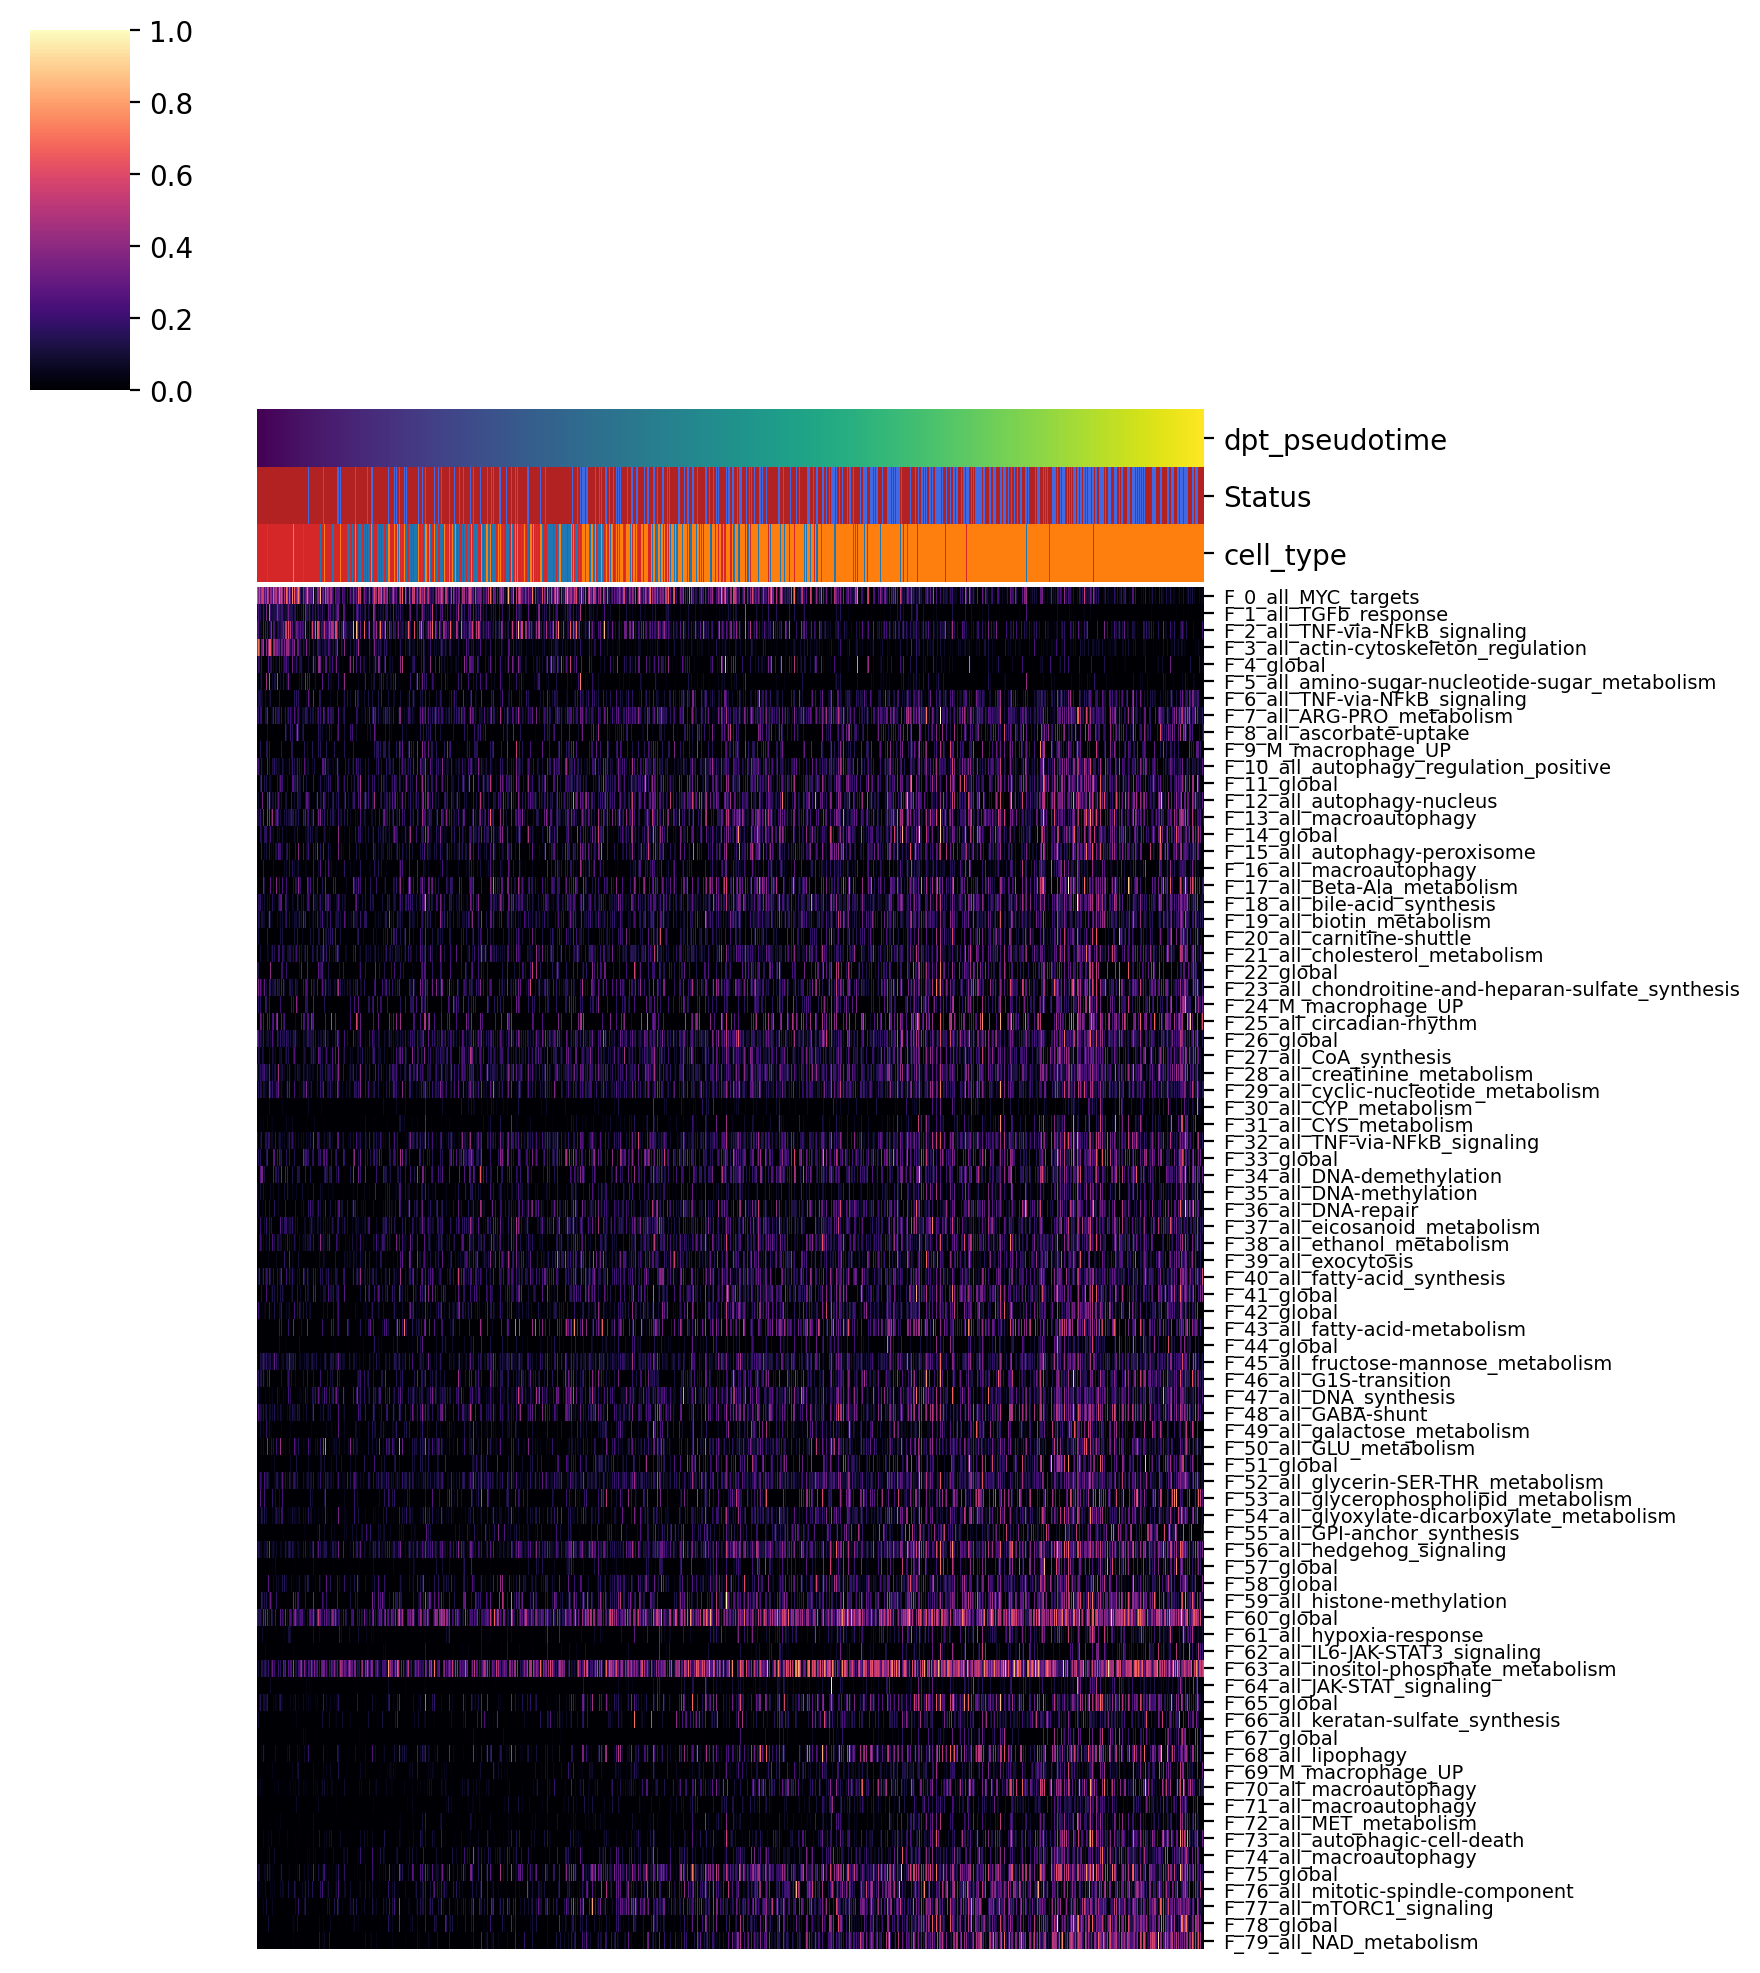

In [31]:
cg = sns.clustermap(
    df.loc[:, factor_idx].T.loc[factor_order],
    col_colors=col_colors,
    col_cluster=False,
    row_cluster=False,
    standard_scale=0,
    cmap='magma',
    method='ward',
    xticklabels=[],
    yticklabels=df.columns[factor_idx]
)
cg.ax_heatmap.tick_params(labelsize=7)

## 3.3 Correlate with lineage committment

In [32]:
factor_idx = ds.obs.columns.str.startswith('F_')

In [33]:
stats = []
for factor in ds.obs.columns[factor_idx]:
    # Not a myeloid factor
    if ds.obs[factor].max() == 0:
        continue
    for lineage in LINEAGES:
        res = scipy.stats.pearsonr(ds.obs[f'Lineage {lineage}'], ds.obs[factor])
        stats.append((lineage, factor, res.statistic, res.pvalue))
stats = pd.DataFrame(stats, columns=['lineage', 'factor', 'pearson_r', 'pval'])
stats.loc[stats.pval.eq(0), 'pval'] = stats.pval[stats.pval.gt(0)].min() * 0.1
stats['padj'] = statsmodels.stats.multitest.fdrcorrection(stats.pval)[1]

<Axes: ylabel='Frequency'>

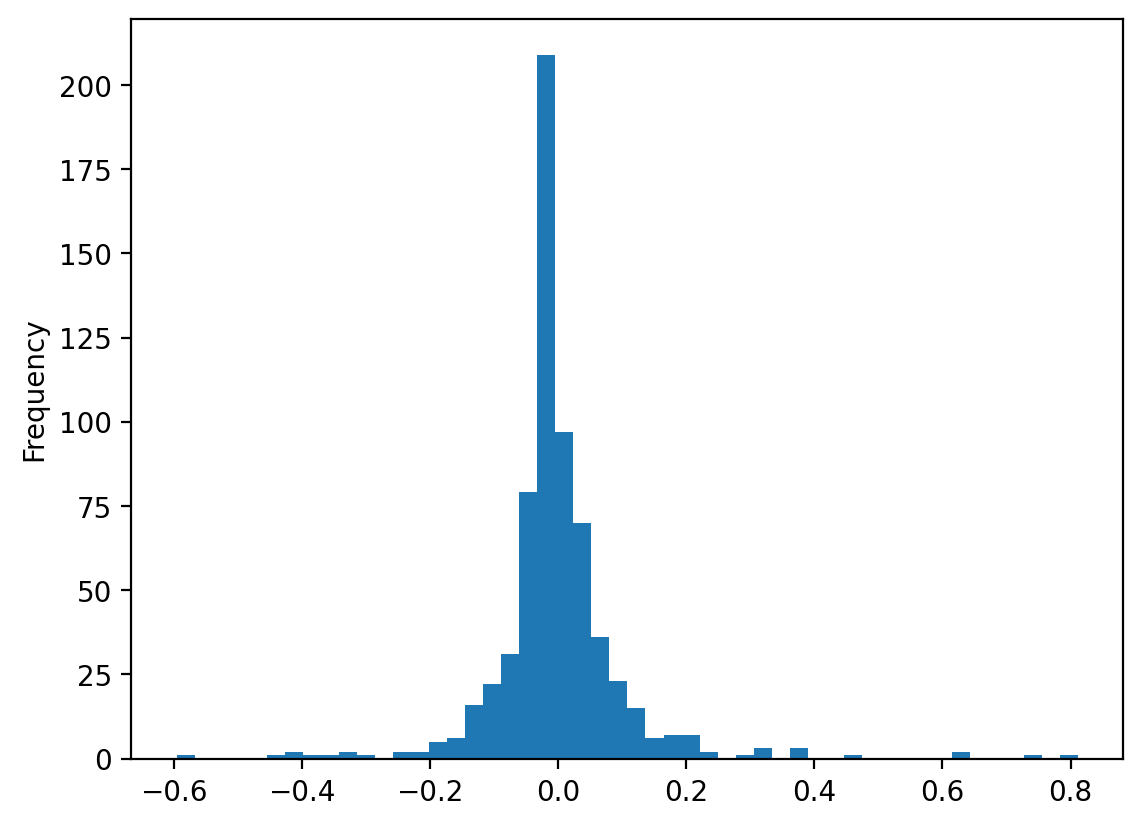

In [34]:
stats.pearson_r.plot.hist(bins=50)

In [69]:
stats.sort_values('pearson_r').tail(30)

lineage  \
515  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
388                   MoAM-4 profibrotic   
167  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
263  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
506                     TRAM-6 activated   
627  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
140                   MoAM-4 profibrotic   
79   TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
241             Perivascular macrophages   
103  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
648                   MoAM-4 profibrotic   
443  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
179  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
575  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
26                      TRAM-6 activated   
630                     TRAM-6 activated   
593             Perivascular macrophages   
623  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
649             Perivascular macrophages   
591  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
329             Perivascular macrophages   
615  TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G   
641             Perivascular macrophages   
640                   MoAM-4 profibrotic   
240                   MoAM-4 profibrotic   
328                   MoAM-4 profibrotic   
582                     TRAM-6 activated   
420                   MoAM-4 profibrotic   
130                     TRAM-6 activated   
537             Perivascular macrophages   

                                   factor  pearson_r           pval  \
515        F_128_all_ubiquinone_synthesis   0.150589  1.955166e-319   
388                           F_97_global   0.159074  1.955166e-319   
167                           F_41_global   0.169202  1.955166e-319   
263                           F_65_global   0.172607  1.955166e-319   
506                          F_126_global   0.176606  1.955166e-319   
627                             F_163_Mac   0.180907  1.955166e-319   
140              F_35_all_DNA-methylation   0.182067  1.955166e-319   
79             F_19_all_biotin_metabolism   0.182508  1.955166e-319   
241                           F_60_global   0.184759  1.955166e-319   
103             F_25_all_circadian-rhythm   0.198629  1.955166e-319   
648                             F_169_Mac   0.199196  1.955166e-319   
443                          F_110_global   0.199269  1.955166e-319   
179                           F_44_global   0.199423  1.955166e-319   
575                          F_143_global   0.199603  1.955166e-319   
26         F_6_all_TNF-via-NFkB_signaling   0.199829  1.955166e-319   
630  F_164_Mac_all_TNF-via-NFkB_signaling   0.210417  1.955166e-319   
593                          F_148_global   0.238192  1.955166e-319   
623                             F_162_Mac   0.246709  1.955166e-319   
649                             F_169_Mac   0.282346  1.955166e-319   
591                          F_147_global   0.322858  1.955166e-319   
329                  F_82_M_macrophage_UP   0.328476  1.955166e-319   
615             F_160_Mac_M_macrophage_UP   0.329933  1.955166e-319   
641               F_167_Mac_M_monocyte_UP   0.365105  1.955166e-319   
640               F_167_Mac_M_monocyte_UP   0.368551  1.955166e-319   
240                           F_60_global   0.386807  1.955166e-319   
328                  F_82_M_macrophage_UP   0.460109  1.955166e-319   
582                        F_145_all_SASP   0.615555  1.955166e-319   
420         F_105_all_pyruvate_metabolism   0.630111  1.955166e-319   
130       F_32_all_TNF-via-NFkB_signaling   0.728272  1.955166e-319   
537                          F_134_global   0.812130  1.955166e-319   

              padj  
515  1.096228e-318  
388  1.096228e-318  
167  1.096228e-318  
263  1.096228e-318  
506  1.096228e-318  
627  1.096228e-318  
140  1.096228e-318  
79   1.096228e-318  
241  1.096228e-318  
103  1.096228e-318  
648  1.096228e-318  
443  1.096228e-318  
179  1.096228e-318  
575  1.096228e-318  
26   1.096228e-318  
630  1.096228e-318  
593  1.096228e-318  
623  1.096228e-318  
649  1.096228e-318  
591  1.096228e-318  
329  1.096228e-318  
615 

In [54]:
factors = []
for l in stats.lineage.unique():
    for factor in stats.loc[
        stats.padj.lt(0.001)
        & stats.lineage.eq(l)
    ].sort_values('pearson_r', key=lambda x: x).factor.tail(10):
        factors.append((l, factor))

In [55]:
factors = pd.DataFrame(factors, columns=['lineage', 'factor'])

In [56]:
factors.index = factors.factor

In [57]:
factor_idx_2 = df.columns.str.startswith('F_')

Plot top 10 factor for lineage. Lineages in order:

In [58]:
stats.lineage.unique()

array(['MoAM-4 profibrotic', 'Perivascular macrophages',
       'TRAM-6 activated', 'TRAM-1, TRAM-2, TRAM-4, TRAM-5 MT1G'],
      dtype=object)

In [70]:
df = ds.obs.loc[ds.obs.cell_type.isin(
    ['Monocytes', 'MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic', 'TRAM-1', 'Perivascular macrophages']
)].copy()

In [71]:
factor_idx = df.columns.str.startswith('F_')

In [72]:
non_myeloid_factors = df.columns[factor_idx][df.loc[:, factor_idx].max().eq(0)]

In [73]:
df.drop(columns=non_myeloid_factors, inplace=True)

In [74]:
factor_idx = df.columns.str.startswith('F_')

In [75]:
df = df.sort_values('dpt_pseudotime')

In [76]:
df.cell_type = df.cell_type.cat.remove_unused_categories()

In [77]:
df.cell_type.cat.categories

Index(['MoAM-1', 'MoAM-3 mature', 'MoAM-4 profibrotic', 'Monocytes',
       'Perivascular macrophages', 'TRAM-1'],
      dtype='object')

In [78]:
col_colors = get_color_annotations(df, {
    'dpt_pseudotime': 'viridis',
    'Status': ['firebrick', 'royalblue'],
    'cell_type': 'tab10'
})

/tmp/ipykernel_14384/280344997.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):
/tmp/ipykernel_14384/280344997.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):


/tmp/ipykernel_14384/280344997.py:5: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df[column]):


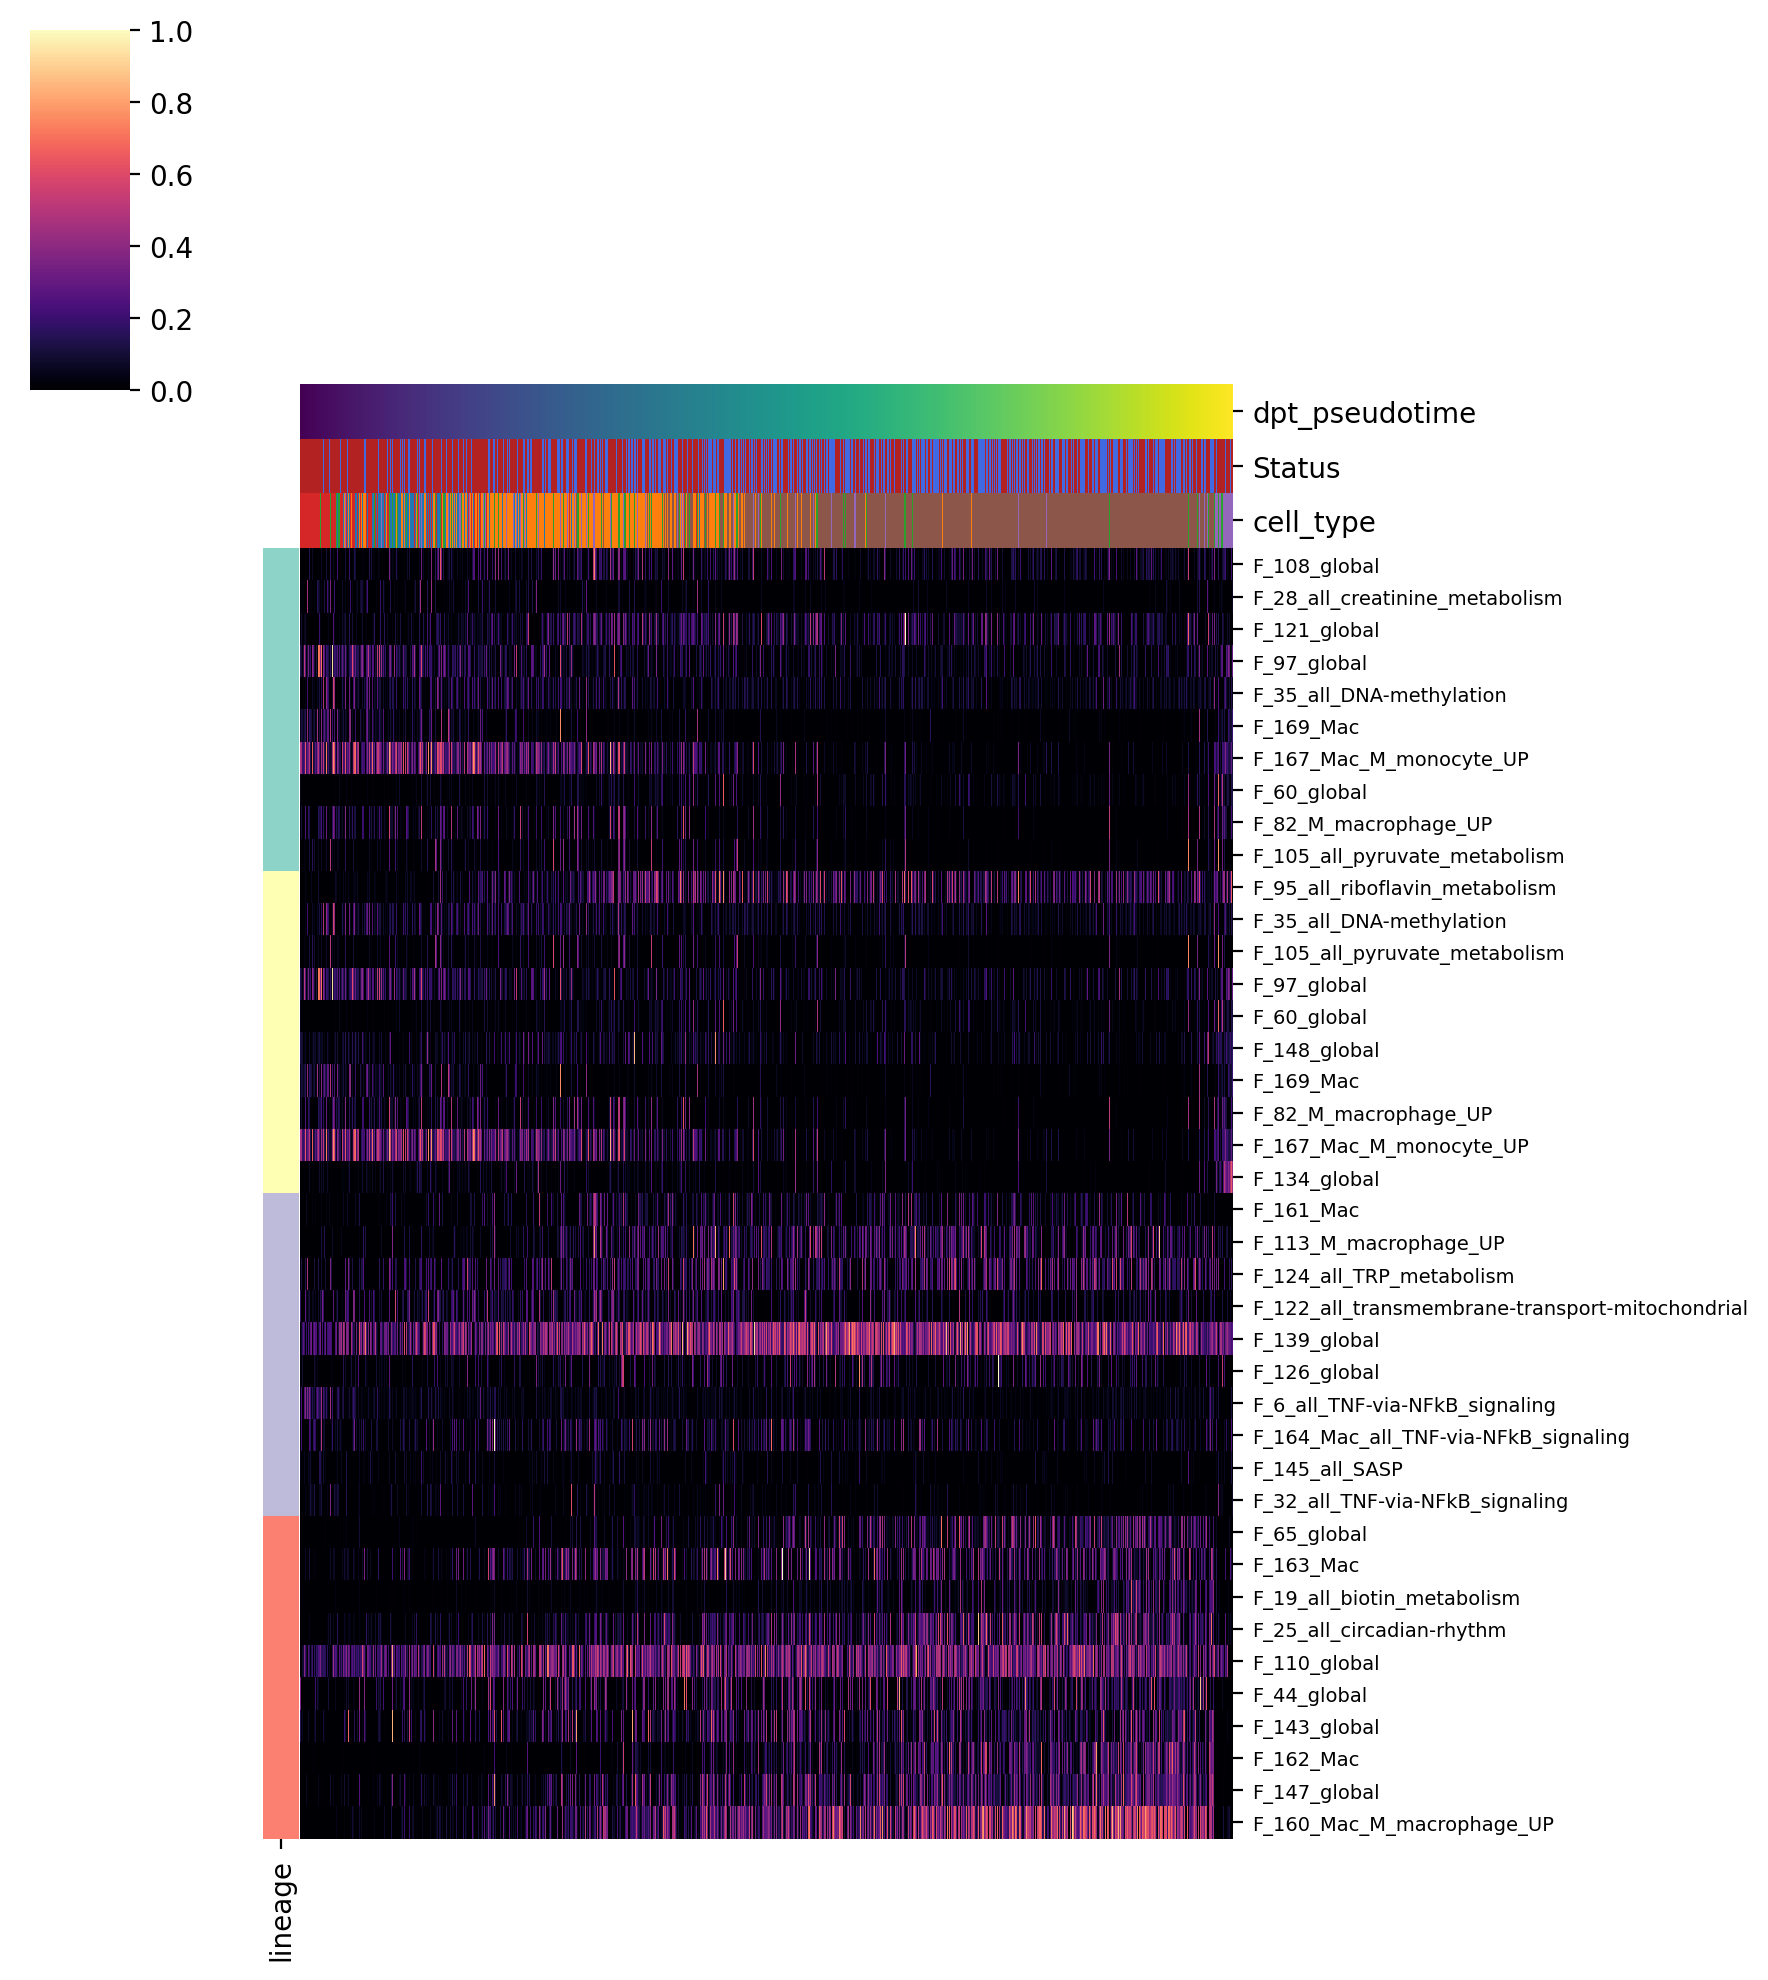

In [79]:
cg = sns.clustermap(
    df.loc[:, factor_idx_2].T.loc[factors.factor.values],
    col_colors=col_colors,
    row_colors=get_color_annotations(factors, {
        'lineage': 'Set3'
    }),
    col_cluster=False,
    row_cluster=False,
    standard_scale=0,
    cmap='magma',
    method='ward',
    xticklabels=[],
    yticklabels=factors.factor.values
)
cg.ax_heatmap.tick_params(labelsize=7)